In [1]:
# 파일 이름: 01_build_ultimate_dataset.py
# 역할: 모든 원본 데이터를 불러와, 팩터와 매크로 지표(Feature)를 만들고,
#       알파/리스크 모델 학습에 필요한 정답(Label)을 생성하여
#       최종 머신러닝 데이터셋을 만드는 스크립트.

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. 데이터 로드 함수 ---
def load_base_data(stock_filepath, macro_filepath):
    """모든 원본 데이터를 불러오고 기본 전처리를 수행합니다."""
    print("원본 데이터 로드를 시작합니다...")
    if not os.path.exists(stock_filepath) or not os.path.exists(macro_filepath):
        raise FileNotFoundError("필요한 원본 데이터 파일이 없습니다.")
        
    stock_df = pd.read_csv(stock_filepath, parse_dates=['기준월'])
    try:
        macro_df = pd.read_csv(macro_filepath, encoding='cp949')
    except UnicodeDecodeError:
        macro_df = pd.read_csv(macro_filepath, encoding='utf-8')
    macro_df['기준월'] = pd.to_datetime(macro_df['연도'].astype(str) + '-' + macro_df['월'].astype(str), format='%Y-%m')
    print("✅ 원본 데이터 로드 완료!")
    return stock_df, macro_df

# --- 2. Feature 생성 함수들 ---
def prepare_all_factors(df):
    print("모든 팩터를 생성하고 스케일링합니다...")
    df = df.copy()

    # ✅ 수정된 팩터 리스트
    factor_list = [
        'value_score', 'quality_score', 'momentum_score', 'size_score',
        'volatility_score', 'op_margin_score', 'attention_score', 'mean_reversion_score'
    ]

    # 팩터 계산
    df['pbr_score'] = -df['PBR']
    df['per_score'] = -df['PER']
    df['psr_score'] = -df['PSR']
    df['value_score'] = df[['pbr_score', 'per_score', 'psr_score']].mean(axis=1)

    df['quality_score'] = df['ROE']
    df['momentum_score'] = df['12개월수익률']
    df['size_score'] = -df['시가총액']

    df = df.sort_values(by=['종목코드', '기준월'])
    df['volatility'] = df.groupby('종목코드')['1개월수익률'].transform(lambda x: x.rolling(12, 6).std())
    df['volatility_score'] = -df['volatility']
    df['op_margin_score'] = df['영업이익률']
    df['attention_score'] = df['평균거래량증가율'] + df['거래회전율']
    df['mean_reversion_score'] = -df['1개월수익률']

    for col in factor_list:
        df[col] = df.groupby('기준월')[col].transform(
            lambda x: (x - x.min()) / (x.max() - x.min()) if x.nunique() > 1 else 0.5
        )
    df[factor_list] = df[factor_list].fillna(0.5)
    print("✅ 모든 팩터 준비 완료!")
    return df

def create_themed_macro_indices(macro_df):
    print("테마별 매크로 인덱스를 생성합니다..."); macro_proc = macro_df.set_index('기준월').copy(); macro_cols = ['WTI', 'VIX', '실업률', 'CPI', '금리', '환율']
    for col in macro_cols:
        change = macro_proc[col].diff(6); mean = change.rolling(24).mean(); std = change.rolling(24).std(); macro_proc[f'{col}_z_score'] = ((change - mean) / std).fillna(0)
    economy_cols, inflation_cols, sentiment_cols = ['실업률_z_score', '금리_z_score'], ['CPI_z_score', 'WTI_z_score'], ['VIX_z_score', '환율_z_score']
    macro_proc['Economy_Index'] = macro_proc[economy_cols].mean(axis=1) * -1; macro_proc['Inflation_Index'] = macro_proc[inflation_cols].mean(axis=1) * -1; macro_proc['Sentiment_Index'] = macro_proc[sentiment_cols].mean(axis=1) * -1
    feature_cols = ['Economy_Index', 'Inflation_Index', 'Sentiment_Index']; final_features = macro_proc[feature_cols].ffill().bfill()
    print("✅ 테마별 매크로 인덱스 생성 완료!"); return final_features.reset_index()

def create_dual_labels(df_original):
    print("알파/리스크 모델용 정답(Label) 데이터를 생성합니다..."); df = df_original.copy(); df['next_month_return'] = df.groupby('종목코드')['1개월수익률'].shift(-1)
    df['y_alpha'] = (df['next_month_return'] > 0).astype(int); df['y_risk'] = (df['next_month_return'] < -0.15).astype(int)
    df.dropna(subset=['next_month_return'], inplace=True); print("✅ 정답 데이터 생성 완료!"); return df[['기준월', '종목코드', 'y_alpha', 'y_risk']]

if __name__ == '__main__':
    stock_filepath = "stock_0.3ver.csv"; macro_filepath = "거시경제 월별 지표 최종.csv"
    stock_df_raw, macro_df_raw = load_base_data(stock_filepath, macro_filepath)
    df_with_all_factors = prepare_all_factors(stock_df_raw)
    macro_features = create_themed_macro_indices(macro_df_raw)
    labels_df = create_dual_labels(stock_df_raw)
    
    print("모든 Feature와 Label을 최종 결합합니다...")
    final_df = pd.merge(df_with_all_factors, macro_features, on='기준월', how='left')
    final_df = pd.merge(final_df, labels_df, on=['기준월', '종목코드'], how='inner')
    final_df.ffill(inplace=True)

    print("Feature 중요도를 계산하여 최적의 Feature를 선별합니다...")
    features_for_selection = [col for col in final_df.columns if col.endswith('_score') or col.endswith('_Index')]
    X = final_df[features_for_selection]; y = final_df['y_alpha']
    model_for_fs = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model_for_fs.fit(X, y)
    feature_importances = pd.Series(model_for_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_features = feature_importances.head(20).index.tolist()
    print(f"✅ 선택된 최상위 Feature:\n{top_features}")
    
    final_ml_dataset = final_df[['기준월', '종목코드'] + top_features + ['y_alpha', 'y_risk']]
    final_ml_dataset.to_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", index=False)
    # 백테스팅 시 종목 조회를 위해 전체 팩터 데이터도 저장
    df_with_all_factors.to_csv("/Users/gun/Desktop/경종설/퀀트/full_feature_stock_data.csv", index=False)
    
    print("\n--- 모든 데이터 준비가 완료되었습니다! ---"); print("생성된 파일: ultimate_ml_dataset.csv, full_feature_stock_data.csv")
    print("이제 '02_run_final_comparison.py'를 실행하여 백테스트를 진행하세요.")


원본 데이터 로드를 시작합니다...
✅ 원본 데이터 로드 완료!
모든 팩터를 생성하고 스케일링합니다...
✅ 모든 팩터 준비 완료!
테마별 매크로 인덱스를 생성합니다...
✅ 테마별 매크로 인덱스 생성 완료!
알파/리스크 모델용 정답(Label) 데이터를 생성합니다...
✅ 정답 데이터 생성 완료!
모든 Feature와 Label을 최종 결합합니다...
Feature 중요도를 계산하여 최적의 Feature를 선별합니다...
✅ 선택된 최상위 Feature:
['value_score', 'mean_reversion_score', 'quality_score', 'momentum_score', 'size_score', 'op_margin_score', 'attention_score', 'pbr_score', 'psr_score', 'volatility_score', 'per_score', 'Economy_Index', 'Sentiment_Index', 'Inflation_Index']

--- 모든 데이터 준비가 완료되었습니다! ---
생성된 파일: ultimate_ml_dataset.csv, full_feature_stock_data.csv
이제 '02_run_final_comparison.py'를 실행하여 백테스트를 진행하세요.


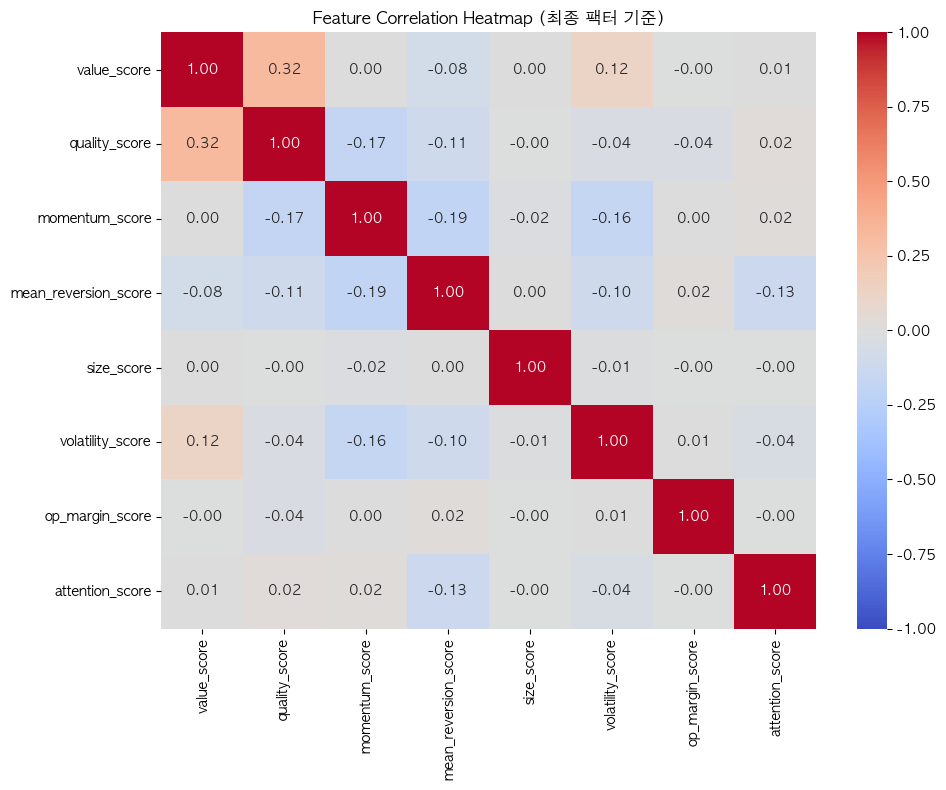

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    plt.rc('font', family='AppleGothic')
except Exception as e:
    print(f"폰트 설정 오류: {e}. 기본 폰트로 설정됩니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- 데이터 불러오기 ---
df = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/full_feature_stock_data.csv")

# ✅ 최종 선정된 팩터 목록
factor_cols = [
    'value_score',
    'quality_score',
    'momentum_score',
    'mean_reversion_score',
    'size_score',
    'volatility_score',
    'op_margin_score',
    'attention_score'
]

# --- 피쳐 간 상관관계 계산 ---
corr = df[factor_cols].corr()

# --- 시각화 ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap (최종 팩터 기준)")
plt.tight_layout()
plt.show()

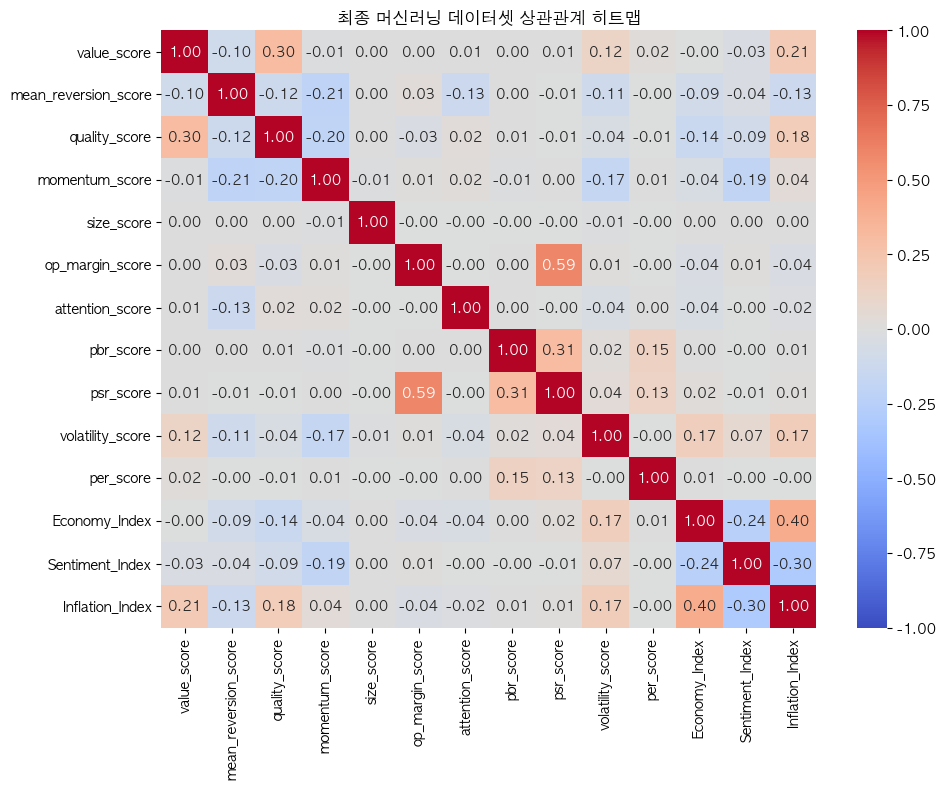

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 데이터 로딩 ---
df = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv")

# --- 피쳐 컬럼 자동 추출 (y값 제외) ---
feature_cols = [col for col in df.columns if col not in ['기준월', '종목코드', 'y_alpha', 'y_risk']]

# --- 상관관계 분석 ---
corr = df[feature_cols].corr()

# --- 시각화 ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("최종 머신러닝 데이터셋 상관관계 히트맵")
plt.tight_layout()
plt.show()

In [4]:
# 파일 이름: 01_build_ultimate_dataset.py (상관관계 제어 기능 추가)

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. 데이터 로드 함수 ---
def load_base_data(stock_filepath, macro_filepath):
    print("원본 데이터 로드를 시작합니다...")
    stock_df = pd.read_csv(stock_filepath, parse_dates=['기준월'])
    try:
        macro_df = pd.read_csv(macro_filepath, encoding='cp949')
    except UnicodeDecodeError:
        macro_df = pd.read_csv(macro_filepath, encoding='utf-8')
    macro_df['기준월'] = pd.to_datetime(macro_df['연도'].astype(str) + '-' + macro_df['월'].astype(str), format='%Y-%m')
    print("✅ 원본 데이터 로드 완료!")
    return stock_df, macro_df

# --- 2. Feature 생성 함수들 ---
def prepare_all_factors(df):
    """보유한 모든 데이터를 활용하여 팩터를 생성하고 스케일링합니다."""
    print("모든 팩터를 생성하고 스케일링합니다...")
    df = df.copy()
    factor_list = ['value_score', 'quality_score', 'momentum_score', 'size_score', 'volatility_score', 'op_margin_score', 'debt_ratio_score', 'robust_momentum_score', 'attention_score']
    df['pbr_score'] = -df['PBR']; df['per_score'] = -df['PER']; df['psr_score'] = -df['PSR']; df['value_score'] = df[['pbr_score', 'per_score', 'psr_score']].mean(axis=1)
    df['quality_score'] = df['ROE']; df['momentum_score'] = df['12개월수익률']; df['size_score'] = -df['시가총액']
    df = df.sort_values(by=['종목코드', '기준월']); df['volatility'] = df.groupby('종목코드')['1개월수익률'].transform(lambda x: x.rolling(12, 6).std()); df['volatility_score'] = -df['volatility']; df['op_margin_score'] = df['영업이익률']; df['debt_ratio_score'] = -df['부채비율']
    df['robust_momentum_score'] = df['momentum_accel'] + df['trend_positive_count'] + df['momentum_trend_slope']; df['attention_score'] = df['평균거래량증가율'] + df['거래회전율']
    for col in factor_list:
        df[col] = df.groupby('기준월')[col].transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.nunique() > 1 else 0.5)
    df[factor_list] = df[factor_list].fillna(0.5); print("✅ 모든 팩터 준비 완료!"); return df

def create_themed_macro_indices(macro_df):
    print("테마별 매크로 인덱스를 생성합니다..."); macro_proc = macro_df.set_index('기준월').copy(); macro_cols = ['WTI', 'VIX', '실업률', 'CPI', '금리', '환율']
    for col in macro_cols:
        change = macro_proc[col].diff(6); mean = change.rolling(24).mean(); std = change.rolling(24).std(); macro_proc[f'{col}_z_score'] = ((change - mean) / std).fillna(0)
    economy_cols, inflation_cols, sentiment_cols = ['실업률_z_score', '금리_z_score'], ['CPI_z_score', 'WTI_z_score'], ['VIX_z_score', '환율_z_score']
    macro_proc['Economy_Index'] = macro_proc[economy_cols].mean(axis=1) * -1; macro_proc['Inflation_Index'] = macro_proc[inflation_cols].mean(axis=1) * -1; macro_proc['Sentiment_Index'] = macro_proc[sentiment_cols].mean(axis=1) * -1
    feature_cols = ['Economy_Index', 'Inflation_Index', 'Sentiment_Index']; final_features = macro_proc[feature_cols].ffill().bfill()
    print("✅ 테마별 매크로 인덱스 생성 완료!"); return final_features.reset_index()

def create_dual_labels(df_original):
    print("알파/리스크 모델용 정답(Label) 데이터를 생성합니다..."); df = df_original.copy(); df['next_month_return'] = df.groupby('종목코드')['1개월수익률'].shift(-1)
    df['y_alpha'] = (df['next_month_return'] > 0).astype(int); df['y_risk'] = (df['next_month_return'] < -0.15).astype(int)
    df.dropna(subset=['next_month_return'], inplace=True); print("✅ 정답 데이터 생성 완료!"); return df[['기준월', '종목코드', 'y_alpha', 'y_risk']]

def remove_highly_correlated_features(df, threshold=0.8):
    """상관계수가 높은 피쳐 중 하나를 제거하여 다중공선성 문제를 해결합니다."""
    print(f"상관계수 임계값 {threshold} 초과 피쳐를 제거합니다...")
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    if not to_drop:
        print("✅ 제거할 피쳐가 없습니다.")
    else:
        print(f"✅ 제거된 피쳐: {to_drop}")
        
    return df.drop(to_drop, axis=1)

if __name__ == '__main__':
    stock_filepath = "/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv"; macro_filepath = "거시경제 월별 지표 최종.csv"
    stock_df_raw, macro_df_raw = load_base_data(stock_filepath, macro_filepath)
    df_with_factors = prepare_all_factors(stock_df_raw)
    macro_features = create_themed_macro_indices(macro_df_raw)
    labels_df = create_dual_labels(stock_df_raw)
    
    print("모든 Feature와 Label을 최종 결합합니다...")
    final_df = pd.merge(df_with_factors, macro_features, on='기준월', how='left')
    final_df = pd.merge(final_df, labels_df, on=['기준월', '종목코드'], how='inner')
    final_df.ffill(inplace=True)

    # 머신러닝 모델에 사용할 최종 피쳐셋 정의
    features_to_use = [col for col in final_df.columns if col.endswith('_score') or col.endswith('_Index')]
    feature_df = final_df[features_to_use]
    
    # --- 여기가 추가된 부분 ---
    # 1. 상관관계 높은 피쳐 제거
    feature_df_decorrelated = remove_highly_correlated_features(feature_df, threshold=0.8)
    
    # 2. 제거 후 남은 피쳐들로 Feature Importance 재계산
    print("최종 피쳐셋으로 Feature 중요도를 계산합니다...")
    X = feature_df_decorrelated
    y = final_df['y_alpha']
    model_for_fs = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model_for_fs.fit(X, y)
    feature_importances = pd.Series(model_for_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_features = feature_importances.head(15).index.tolist() # 상위 15개 Feature만 선택
    print(f"✅ 선택된 최상위 Feature (상관관계 제어 후):\n{top_features}")
    
    # 3. 최종 머신러닝 데이터셋 저장
    final_ml_dataset = final_df[['기준월', '종목코드'] + top_features + ['y_alpha', 'y_risk']]
    final_ml_dataset.to_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", index=False)
    
    print("\n--- 모든 데이터 준비가 완료되었습니다! ---"); 
    print("생성된 파일: ultimate_ml_dataset.csv")
    print("이제 '02_run_final_comparison.py'를 실행하여 백테스트를 진행하세요.")


원본 데이터 로드를 시작합니다...
✅ 원본 데이터 로드 완료!
모든 팩터를 생성하고 스케일링합니다...
✅ 모든 팩터 준비 완료!
테마별 매크로 인덱스를 생성합니다...
✅ 테마별 매크로 인덱스 생성 완료!
알파/리스크 모델용 정답(Label) 데이터를 생성합니다...
✅ 정답 데이터 생성 완료!
모든 Feature와 Label을 최종 결합합니다...
상관계수 임계값 0.8 초과 피쳐를 제거합니다...
✅ 제거된 피쳐: ['debt_ratio_score']
최종 피쳐셋으로 Feature 중요도를 계산합니다...
✅ 선택된 최상위 Feature (상관관계 제어 후):
['value_score', 'quality_score', 'robust_momentum_score', 'momentum_score', 'size_score', 'attention_score', 'op_margin_score', 'pbr_score', 'psr_score', 'volatility_score', 'per_score', 'Economy_Index', 'Sentiment_Index', 'Inflation_Index']

--- 모든 데이터 준비가 완료되었습니다! ---
생성된 파일: ultimate_ml_dataset.csv
이제 '02_run_final_comparison.py'를 실행하여 백테스트를 진행하세요.


원본 데이터 로드를 시작합니다...
✅ 원본 데이터 로드 완료!
모든 팩터를 생성하고 스케일링합니다...
✅ 모든 팩터 준비 완료!
테마별 매크로 인덱스를 생성합니다...
✅ 테마별 매크로 인덱스 생성 완료!
알파/리스크 모델용 정답(Label) 데이터를 생성합니다...
✅ 정답 데이터 생성 완료!
모든 Feature와 Label을 최종 결합합니다...
상관계수 임계값 0.8 초과 피쳐를 제거합니다...
✅ 상관관계가 높아 제거된 피쳐: ['debt_ratio_score']
상관계수가 제어된 최종 피쳐셋의 히트맵을 시각화합니다...


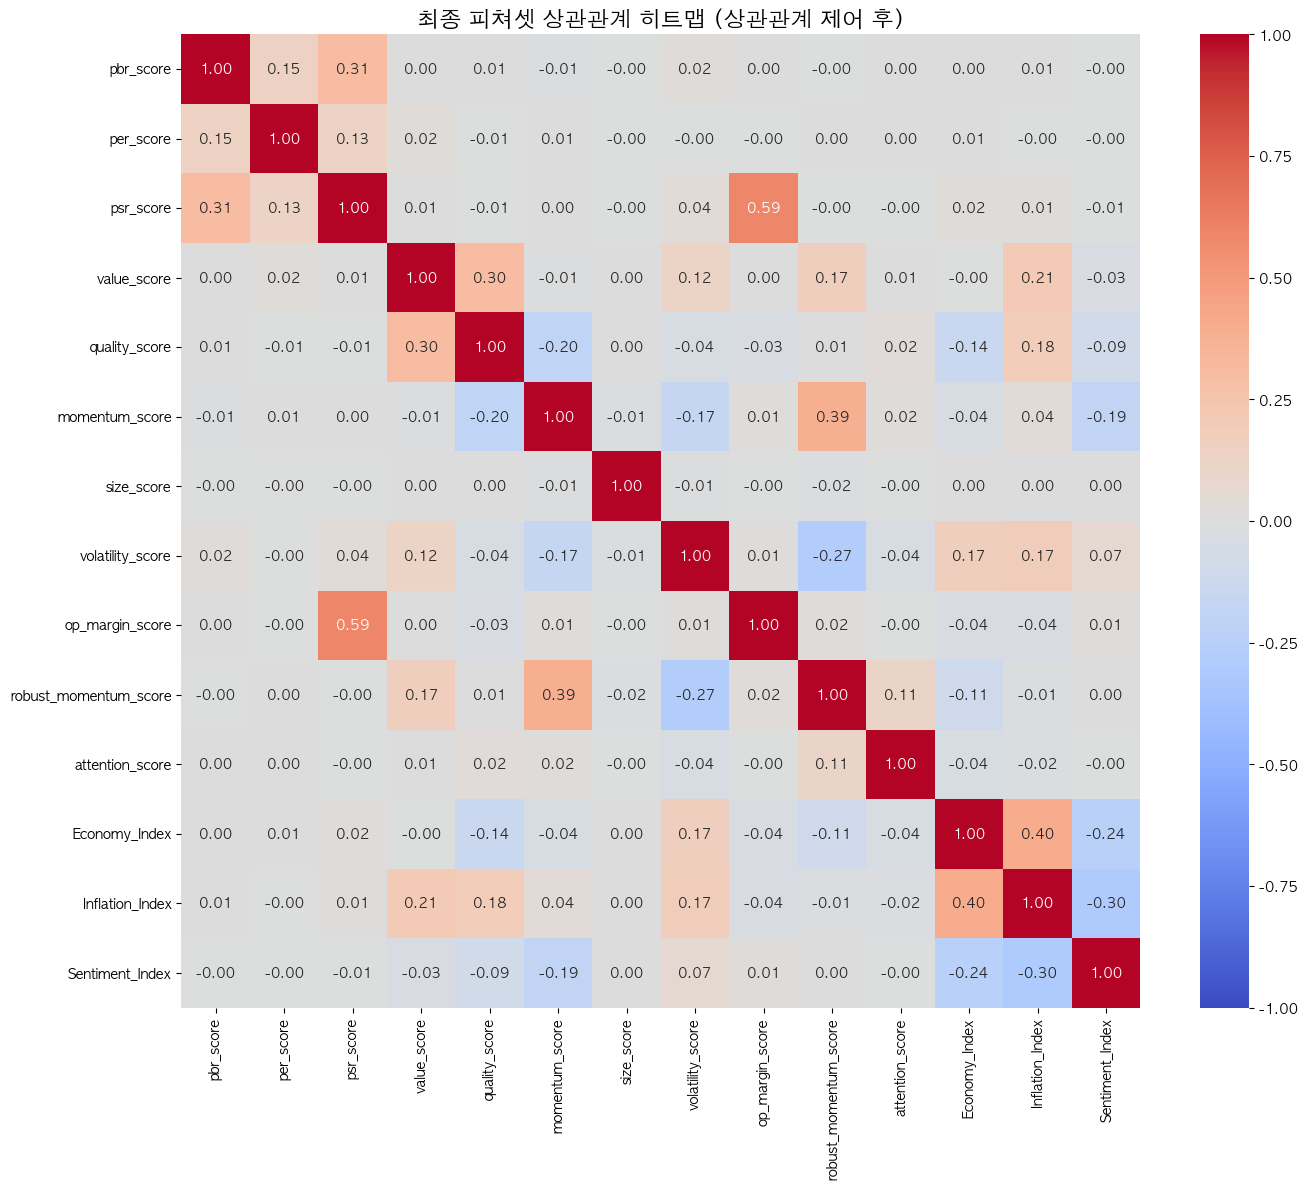

최종 피쳐셋으로 Feature 중요도를 계산합니다...
✅ 선택된 최상위 Feature (상관관계 제어 후):
['value_score', 'quality_score', 'robust_momentum_score', 'momentum_score', 'size_score', 'attention_score', 'op_margin_score', 'pbr_score', 'psr_score', 'volatility_score', 'per_score', 'Economy_Index', 'Sentiment_Index', 'Inflation_Index']

--- 모든 데이터 준비가 완료되었습니다! ---
생성된 파일: ultimate_ml_dataset.csv
이제 '02_run_final_comparison.py'를 실행하여 백테스트를 진행하세요.


In [5]:
# 파일 이름: 01_build_ultimate_dataset.py (상관관계 제어 및 시각화 기능 추가)

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# --- Matplotlib 한글 폰트 설정 ---
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        print("한글 폰트 설정에 실패했습니다. 기본 폰트로 설정됩니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- 1. 데이터 로드 함수 ---
def load_base_data(stock_filepath, macro_filepath):
    print("원본 데이터 로드를 시작합니다...")
    stock_df = pd.read_csv(stock_filepath, parse_dates=['기준월'])
    try:
        macro_df = pd.read_csv(macro_filepath, encoding='cp949')
    except UnicodeDecodeError:
        macro_df = pd.read_csv(macro_filepath, encoding='utf-8')
    macro_df['기준월'] = pd.to_datetime(macro_df['연도'].astype(str) + '-' + macro_df['월'].astype(str), format='%Y-%m')
    print("✅ 원본 데이터 로드 완료!")
    return stock_df, macro_df

# --- 2. Feature 생성 함수들 ---
def prepare_all_factors(df):
    """보유한 모든 데이터를 활용하여 팩터를 생성하고 스케일링합니다."""
    print("모든 팩터를 생성하고 스케일링합니다...")
    df = df.copy()
    factor_list = ['value_score', 'quality_score', 'momentum_score', 'size_score', 'volatility_score', 'op_margin_score', 'debt_ratio_score', 'robust_momentum_score', 'attention_score']
    df['pbr_score'] = -df['PBR']; df['per_score'] = -df['PER']; df['psr_score'] = -df['PSR']; df['value_score'] = df[['pbr_score', 'per_score', 'psr_score']].mean(axis=1)
    df['quality_score'] = df['ROE']; df['momentum_score'] = df['12개월수익률']; df['size_score'] = -df['시가총액']
    df = df.sort_values(by=['종목코드', '기준월']); df['volatility'] = df.groupby('종목코드')['1개월수익률'].transform(lambda x: x.rolling(12, 6).std()); df['volatility_score'] = -df['volatility']; df['op_margin_score'] = df['영업이익률']; df['debt_ratio_score'] = -df['부채비율']
    df['robust_momentum_score'] = df['momentum_accel'] + df['trend_positive_count'] + df['momentum_trend_slope']; df['attention_score'] = df['평균거래량증가율'] + df['거래회전율']
    for col in factor_list:
        df[col] = df.groupby('기준월')[col].transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.nunique() > 1 else 0.5)
    df[factor_list] = df[factor_list].fillna(0.5); print("✅ 모든 팩터 준비 완료!"); return df

def create_themed_macro_indices(macro_df):
    print("테마별 매크로 인덱스를 생성합니다..."); macro_proc = macro_df.set_index('기준월').copy(); macro_cols = ['WTI', 'VIX', '실업률', 'CPI', '금리', '환율']
    for col in macro_cols:
        change = macro_proc[col].diff(6); mean = change.rolling(24).mean(); std = change.rolling(24).std(); macro_proc[f'{col}_z_score'] = ((change - mean) / std).fillna(0)
    economy_cols, inflation_cols, sentiment_cols = ['실업률_z_score', '금리_z_score'], ['CPI_z_score', 'WTI_z_score'], ['VIX_z_score', '환율_z_score']
    macro_proc['Economy_Index'] = macro_proc[economy_cols].mean(axis=1) * -1; macro_proc['Inflation_Index'] = macro_proc[inflation_cols].mean(axis=1) * -1; macro_proc['Sentiment_Index'] = macro_proc[sentiment_cols].mean(axis=1) * -1
    feature_cols = ['Economy_Index', 'Inflation_Index', 'Sentiment_Index']; final_features = macro_proc[feature_cols].ffill().bfill()
    print("✅ 테마별 매크로 인덱스 생성 완료!"); return final_features.reset_index()

def create_dual_labels(df_original):
    print("알파/리스크 모델용 정답(Label) 데이터를 생성합니다..."); df = df_original.copy(); df['next_month_return'] = df.groupby('종목코드')['1개월수익률'].shift(-1)
    df['y_alpha'] = (df['next_month_return'] > 0).astype(int); df['y_risk'] = (df['next_month_return'] < -0.15).astype(int)
    df.dropna(subset=['next_month_return'], inplace=True); print("✅ 정답 데이터 생성 완료!"); return df[['기준월', '종목코드', 'y_alpha', 'y_risk']]

def remove_highly_correlated_features(df, threshold=0.8):
    """상관계수가 높은 피쳐 중 하나를 제거하여 다중공선성 문제를 해결합니다."""
    print(f"상관계수 임계값 {threshold} 초과 피쳐를 제거합니다...")
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    if not to_drop:
        print("✅ 제거할 피쳐가 없습니다.")
    else:
        print(f"✅ 상관관계가 높아 제거된 피쳐: {to_drop}")
        
    return df.drop(to_drop, axis=1)

if __name__ == '__main__':
    stock_filepath = "/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv"; macro_filepath = "거시경제 월별 지표 최종.csv"
    stock_df_raw, macro_df_raw = load_base_data(stock_filepath, macro_filepath)
    df_with_factors = prepare_all_factors(stock_df_raw)
    macro_features = create_themed_macro_indices(macro_df_raw)
    labels_df = create_dual_labels(stock_df_raw)
    
    print("모든 Feature와 Label을 최종 결합합니다...")
    final_df = pd.merge(df_with_factors, macro_features, on='기준월', how='left')
    final_df = pd.merge(final_df, labels_df, on=['기준월', '종목코드'], how='inner')
    final_df.ffill(inplace=True)

    # 머신러닝 모델에 사용할 최종 피쳐셋 정의
    features_to_use = [col for col in final_df.columns if col.endswith('_score') or col.endswith('_Index')]
    feature_df = final_df[features_to_use]
    
    # 1. 상관관계 높은 피쳐 제거
    feature_df_decorrelated = remove_highly_correlated_features(feature_df, threshold=0.8)
    
    # 2. 상관관계 제어 후 히트맵 시각화
    print("상관계수가 제어된 최종 피쳐셋의 히트맵을 시각화합니다...")
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        feature_df_decorrelated.corr(), 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm", 
        vmin=-1, 
        vmax=1
    )
    plt.title("최종 피쳐셋 상관관계 히트맵 (상관관계 제어 후)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 3. 제거 후 남은 피쳐들로 Feature Importance 재계산
    print("최종 피쳐셋으로 Feature 중요도를 계산합니다...")
    X = feature_df_decorrelated
    y = final_df['y_alpha']
    model_for_fs = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model_for_fs.fit(X, y)
    feature_importances = pd.Series(model_for_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_features = feature_importances.head(15).index.tolist()
    print(f"✅ 선택된 최상위 Feature (상관관계 제어 후):\n{top_features}")
    
    # 4. 최종 머신러닝 데이터셋 저장
    final_ml_dataset = final_df[['기준월', '종목코드'] + top_features + ['y_alpha', 'y_risk']]
    final_ml_dataset.to_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", index=False)
    
    print("\n--- 모든 데이터 준비가 완료되었습니다! ---"); 
    print("생성된 파일: ultimate_ml_dataset.csv")
    print("이제 '02_run_final_comparison.py'를 실행하여 백테스트를 진행하세요.")


--- 최종 머신러닝 백테스팅 실행 시작 ---
✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.
✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.
전략 비교 백테스트를 실행합니다 (학습: 36개월)...

--- 학습: 2021-01~2023-12 | 검증: 2024-01~2024-06 ---
  - 알파 모델 학습 중...
[LightGBM] [Info] Number of positive: 25487, number of negative: 29557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2829
[LightGBM] [Info] Number of data points in the train set: 55044, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463030 -> initscore=-0.148152
[LightGBM] [Info] Start training from score -0.148152
  - 리스크 모델 학습 중...
[LightGBM] [Info] Number of positive: 5436, number of negative: 49608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

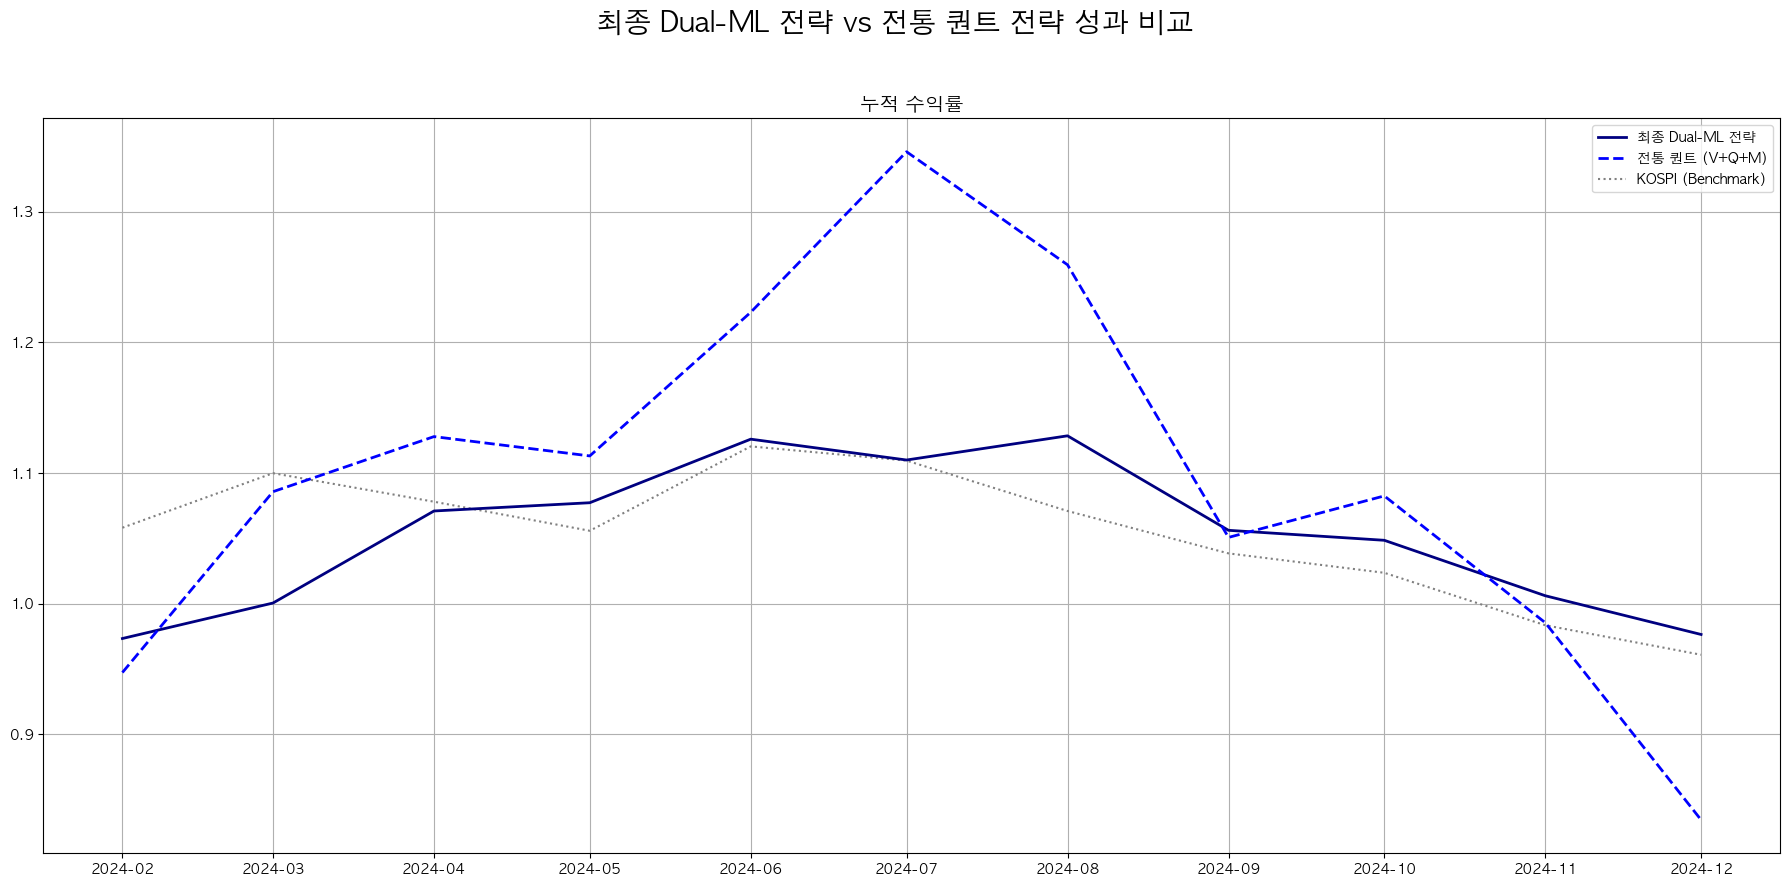

In [6]:
# 파일 이름: 02_run_comparative_backtest.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib 한글 폰트 설정 ---
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        print("한글 폰트 설정에 실패했습니다. 기본 폰트로 설정됩니다.")
plt.rcParams['axes.unicode_minus'] = False

# --- 헬퍼 함수 ---
def get_kospi_data(start_date, end_date):
    """KOSPI 벤치마크 데이터를 수집합니다."""
    print("KOSPI 데이터를 다운로드합니다..."); safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last()
    kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'수익률': kospi_monthly_returns}).reset_index()
    kospi_df_monthly.rename(columns={'Date': '기준월'}, inplace=True)
    kospi_df_monthly['기준월'] = pd.to_datetime(kospi_df_monthly['기준월']).dt.to_period('M').dt.to_timestamp()
    print("✅ KOSPI 데이터 준비 완료!"); return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    """성과 지표를 계산하는 헬퍼 함수"""
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- 최종 비교 백테스터 클래스 ---
class FinalComparativeBacktester:
    def __init__(self, ml_dataset, df_with_factors, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_with_factors = df_with_factors
        self.df_original = df_original
        self.top_n, self.cost = top_n, cost
        
        # --- 여기가 수정된 부분 ---
        # 결과 저장을 위한 변수들을 명확하게 초기화합니다.
        self.returns_df = None
        self.performance_summary = {} # 이 줄이 추가되었습니다.

    def run_backtest_comparison(self, train_months=36, test_months=6):
        print(f"전략 비교 백테스트를 실행합니다 (학습: {train_months}개월)...");
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['기준월'].unique())
        returns_ml, returns_traditional = [], []
        
        current_train_end_idx = train_months
        while current_train_end_idx < len(unique_dates):
            train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
            test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
            if test_start > test_end: break

            print(f"\n--- 학습: {train_start.strftime('%Y-%m')}~{train_end.strftime('%Y-%m')} | 검증: {test_start.strftime('%Y-%m')}~{test_end.strftime('%Y-%m')} ---")
            
            train_data = dataset[dataset['기준월'].between(train_start, train_end)]
            features = [col for col in dataset.columns if col not in ['기준월', '종목코드', 'y_alpha', 'y_risk']]
            X_train, y_alpha_train, y_risk_train = train_data[features], train_data['y_alpha'], train_data['y_risk']
            
            print("  - 알파 모델 학습 중..."); alpha_model = lgb.LGBMClassifier(random_state=42); alpha_model.fit(X_train, y_alpha_train)
            print("  - 리스크 모델 학습 중..."); risk_model = lgb.LGBMClassifier(random_state=42); risk_model.fit(X_train, y_risk_train)

            for date in pd.date_range(test_start, test_end, freq='MS'):
                current_month_data = dataset[dataset['기준월'] == date].copy()
                if current_month_data.empty: continue
                X_test = current_month_data[features]
                
                # --- ML 전략 포트폴리오 ---
                current_month_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                candidate_stocks = current_month_data.nlargest(self.top_n * 2, 'alpha_score')
                X_candidates = candidate_stocks[features]
                candidate_stocks['risk_score'] = risk_model.predict_proba(X_candidates)[:, 1]
                portfolio_ml = candidate_stocks.nsmallest(self.top_n, 'risk_score')['종목코드'].tolist()
                
                # --- 전통 퀀트 전략 포트폴리오 ---
                current_factors_df = self.df_with_factors[self.df_with_factors['기준월'] == date]
                current_factors_df['traditional_score'] = current_factors_df['value_score'] + current_factors_df['quality_score'] + current_factors_df['momentum_score']
                portfolio_traditional = current_factors_df.nlargest(self.top_n, 'traditional_score')['종목코드'].tolist()

                # --- 다음달 수익률 계산 ---
                next_month_date = date + pd.DateOffset(months=1); next_month_data_orig = self.df_original[self.df_original['기준월'] == next_month_date]
                
                next_month_ml = next_month_data_orig[next_month_data_orig['종목코드'].isin(portfolio_ml)]
                returns_ml.append({'기준월': next_month_date, '수익률': (next_month_ml['1개월수익률'].mean() - self.cost) if not next_month_ml.empty else -self.cost})
                
                next_month_trad = next_month_data_orig[next_month_data_orig['종목코드'].isin(portfolio_traditional)]
                returns_traditional.append({'기준월': next_month_date, '수익률': (next_month_trad['1개월수익률'].mean() - self.cost) if not next_month_trad.empty else -self.cost})
            
            current_train_end_idx += test_months
        
        print("\n✅ 백테스트 완료!"); 
        df_ml = pd.DataFrame(returns_ml).set_index('기준월'); df_trad = pd.DataFrame(returns_traditional).set_index('기준월')
        self.returns_df = pd.concat([df_ml, df_trad], axis=1, keys=['Dual-ML 전략', '전통 퀀트']); self.returns_df.columns = self.returns_df.columns.droplevel(1)
        self.performance_summary['Dual-ML 전략'] = calculate_performance_metrics(self.returns_df['Dual-ML 전략'].dropna())
        self.performance_summary['전통 퀀트'] = calculate_performance_metrics(self.returns_df['전통 퀀트'].dropna())
        self.print_performance_summary()

    def print_performance_summary(self):
        print("\n" + "="*60); print(" " * 20 + "- 최종 성과 비교 요약 -"); print("="*60); 
        summary_df = pd.DataFrame.from_dict(self.performance_summary, orient='index');
        for col in summary_df.columns: summary_df[col] = summary_df[col].apply(lambda x: f"{x:.2%}" if col != 'Sharpe Ratio' else f"{x:.2f}")
        print(summary_df); print("="*60)
        
    def plot_results(self, kospi_df):
        if self.returns_df is None or self.returns_df.empty: return
        fig, ax1 = plt.subplots(1, 1, figsize=(18, 9)); fig.suptitle('최종 Dual-ML 전략 vs 전통 퀀트 전략 성과 비교', fontsize=20)
        cum_returns = (1 + self.returns_df.fillna(0)).cumprod(); 
        kospi_returns_aligned = kospi_df.set_index('기준월').loc[cum_returns.index]; 
        cum_returns_kospi = (1 + kospi_returns_aligned['수익률']).cumprod()
        ax1.plot(cum_returns.index, cum_returns['Dual-ML 전략'], label='최종 Dual-ML 전략', color='navy', lw=2, zorder=5)
        ax1.plot(cum_returns.index, cum_returns['전통 퀀트'], label='전통 퀀트 (V+Q+M)', color='blue', ls='--', lw=2, zorder=5)
        ax1.plot(cum_returns_kospi.index, cum_returns_kospi, label='KOSPI (Benchmark)', color='grey', ls=':', zorder=4)
        ax1.set_title('누적 수익률', fontsize=14); ax1.legend(); ax1.grid(True); plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

if __name__ == '__main__':
    print("--- 최종 머신러닝 백테스팅 실행 시작 ---")
    try:
        # 1. 데이터 로드
        ml_dataset = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", parse_dates=['기준월'])
        df_original = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv", parse_dates=['기준월'])
        df_with_factors = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/full_feature_stock_data.csv", parse_dates=['기준월'])
        
        # KOSPI 데이터 로드 (캐싱)
        kospi_filepath = "/Users/gun/Desktop/경종설/퀀트/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['기준월'])
            print("✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.")
        except FileNotFoundError:
            print("⚠️ 저장된 KOSPI 데이터가 없어 새로 다운로드합니다.")
            start_date, end_date = df_original['기준월'].min(), df_original['기준월'].max()
            kospi_df = get_kospi_data(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.")

        # 2. 백테스터 실행
        train_months = 36
        
        ml_backtester = FinalComparativeBacktester(
            ml_dataset=ml_dataset,
            df_with_factors=df_with_factors, 
            df_original=df_original
        )
        ml_backtester.run_backtest_comparison(train_months=train_months, test_months=6)
        ml_backtester.plot_results(kospi_df)

    except FileNotFoundError as e:
        print(f"\n!!! 오류: {e} !!!"); print("먼저 '01_build_ultimate_dataset.py'를 실행하여 데이터 파일을 생성해주세요.")

def plot_metric_comparison(self):
    """모델별 주요 성과지표 시각화"""
    df = pd.DataFrame(self.performance_summary).T
    df = df.rename(columns={"Rank_IC": "Rank IC"})
    df.plot(kind='bar', figsize=(10, 6))
    plt.title("모델별 성능 비교 (R², Rank IC, Hit Ratio, Sharpe Ratio)")
    plt.ylabel("값")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

--- 최종 머신러닝 백테스팅 실행 시작 (모델 비교) ---
✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.
✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.
--- 모델: LogisticRegression | Walk-Forward 백테스트 실행 ---


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linea

--- 모델: RandomForest | Walk-Forward 백테스트 실행 ---
--- 모델: LightGBM | Walk-Forward 백테스트 실행 ---
--- 모델: XGBoost | Walk-Forward 백테스트 실행 ---


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:55:28] WARN


                  - 머신러닝 모델별 최종 성과 비교 -
                       CAGR      MDD Volatility Sharpe Ratio
LogisticRegression  -15.88%  -24.03%     25.76%        -0.62
RandomForest        -13.20%  -12.48%      7.41%        -1.78
LightGBM              8.14%   -7.16%     16.28%         0.50
XGBoost             -18.02%  -17.11%     10.70%        -1.68


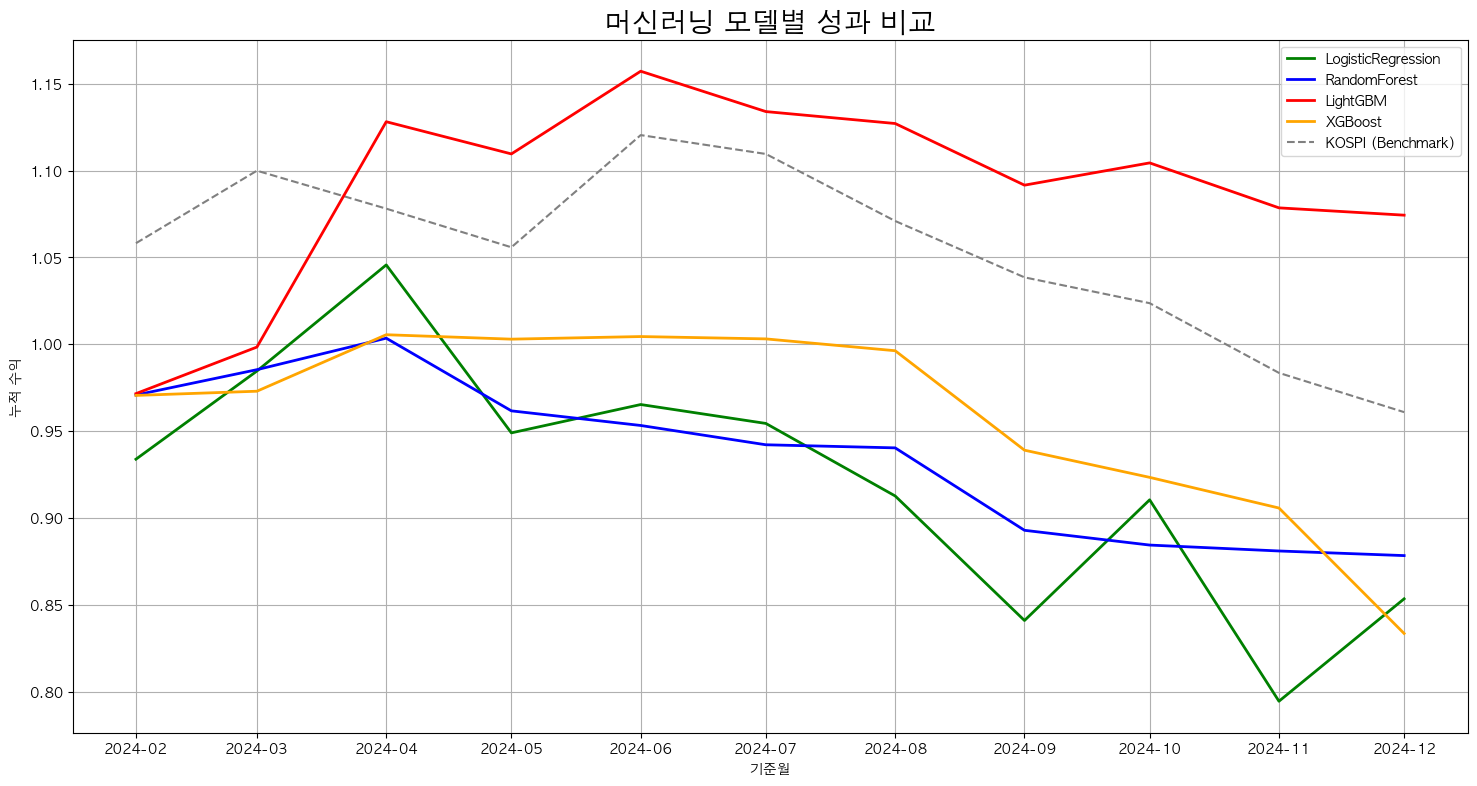

In [7]:
# 파일 이름: 02_run_model_comparison_final.py
# 역할: 3대 머신러닝 모델(로지스틱 회귀, 랜덤 포레스트, LightGBM, XGBoost)을
#       모두 사용하여 백테스팅하고, 그 성과를 종합적으로 비교 분석하는 최종 스크립트.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb # XGBoost 임포트
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib 한글 폰트 설정 ---
try: plt.rc('font', family='AppleGothic')
except: plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# --- 헬퍼 함수 ---
def get_kospi_data_for_caching(start_date, end_date):
    """(캐시 생성용) KOSPI 월별 수익률 데이터를 수집합니다."""
    print("KOSPI 벤치마크 데이터를 다운로드합니다..."); safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last(); kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'수익률': kospi_monthly_returns}).reset_index(); kospi_df_monthly.rename(columns={'Date': '기준월'}, inplace=True)
    kospi_df_monthly['기준월'] = pd.to_datetime(kospi_df_monthly['기준월']).dt.to_period('M').dt.to_timestamp()
    print("✅ KOSPI 데이터 준비 완료!"); return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    """성과 지표를 계산하는 헬퍼 함수"""
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- 최종 비교 백테스터 클래스 ---
class DualMachineLearningBacktester:
    def __init__(self, ml_dataset, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset; self.df_original = df_original
        self.top_n, self.cost = top_n, cost

    def run_walk_forward_backtest(self, alpha_model, risk_model, model_name, train_months=36, test_months=6):
        """확장 윈도우 방식으로 주어진 듀얼 ML 모델을 학습하고 백테스트 수익률을 반환합니다."""
        print(f"--- 모델: {model_name} | Walk-Forward 백테스트 실행 ---")
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['기준월'].unique())
        monthly_returns = []
        
        current_train_end_idx = train_months
        while current_train_end_idx < len(unique_dates):
            train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
            test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
            if test_start > test_end: break

            train_data = dataset[dataset['기준월'].between(train_start, train_end)]
            features = [col for col in dataset.columns if col not in ['기준월', '종목코드', 'y_alpha', 'y_risk']]
            X_train, y_alpha_train, y_risk_train = train_data[features], train_data['y_alpha'], train_data['y_risk']
            
            alpha_model.fit(X_train, y_alpha_train); risk_model.fit(X_train, y_risk_train)

            for date in pd.date_range(test_start, test_end, freq='MS'):
                current_month_data = dataset[dataset['기준월'] == date].copy()
                if current_month_data.empty: continue
                X_test = current_month_data[features]
                
                current_month_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                candidate_stocks = current_month_data.nlargest(50, 'alpha_score') # 이 부분을 수정
                X_candidates = candidate_stocks[features]
                candidate_stocks['risk_score'] = risk_model.predict_proba(X_candidates)[:, 1]
                final_portfolio_stocks = candidate_stocks.nsmallest(self.top_n, 'risk_score')['종목코드'].tolist()
                
                next_month_date = date + pd.DateOffset(months=1); next_month_data_orig = self.df_original[self.df_original['기준월'] == next_month_date]
                next_month_returns = next_month_data_orig[next_month_data_orig['종목코드'].isin(final_portfolio_stocks)]
                monthly_return = (next_month_returns['1개월수익률'].mean() - self.cost) if not next_month_returns.empty else -self.cost
                monthly_returns.append({'기준월': next_month_date, '수익률': monthly_return})
            
            current_train_end_idx += test_months
        
        return pd.DataFrame(monthly_returns).set_index('기준월')['수익률']

# --- 메인 실행 블록 ---
if __name__ == '__main__':
    print("--- 최종 머신러닝 백테스팅 실행 시작 (모델 비교) ---")
    try:
        # 1. 데이터 로드
        ml_dataset = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", parse_dates=['기준월'])
        df_original = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv", parse_dates=['기준월'])
        
        kospi_filepath = "/Users/gun/Desktop/경종설/퀀트/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['기준월'])
            print("✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.")
        except FileNotFoundError:
            print("⚠️ 저장된 KOSPI 데이터가 없어 새로 다운로드합니다.")
            start_date, end_date = df_original['기준월'].min(), df_original['기준월'].max()
            kospi_df = get_kospi_data_for_caching(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.")

        # 2. 백테스터 객체 생성
        backtester = DualMachineLearningBacktester(ml_dataset=ml_dataset, df_original=df_original)
        
        # 3. 비교할 모델들 정의
        models_to_test = {
            'LogisticRegression': (LogisticRegression(random_state=42, max_iter=1000), LogisticRegression(random_state=42, max_iter=1000)),
            'RandomForest': (RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
            'LightGBM': (lgb.LGBMClassifier(random_state=42, verbosity=-1), lgb.LGBMClassifier(random_state=42, verbosity=-1)),
            'XGBoost': (xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
        }
        
        all_results = {}; all_returns = {}; train_months = 36

        # 4. 각 모델에 대해 백테스트 실행
        for name, (alpha_model, risk_model) in models_to_test.items():
            returns = backtester.run_walk_forward_backtest(alpha_model, risk_model, name, train_months=train_months, test_months=6)
            all_returns[name] = returns; all_results[name] = calculate_performance_metrics(returns)
        
        # 5. 최종 결과 비교 출력
        print("\n" + "="*60); print(" " * 18 + "- 머신러닝 모델별 최종 성과 비교 -"); print("="*60)
        summary_df = pd.DataFrame.from_dict(all_results, orient='index')
        for col in summary_df.columns:
            summary_df[col] = summary_df[col].apply(lambda x: f"{x:.2%}" if col != 'Sharpe Ratio' else f"{x:.2f}")
        print(summary_df); print("="*60)
        
        # 6. 최종 결과 시각화
        returns_df_all = pd.concat(all_returns, axis=1); cum_returns = (1 + returns_df_all.fillna(0)).cumprod()
        kospi_returns_aligned = kospi_df.set_index('기준월').loc[cum_returns.index]; cum_returns_kospi = (1 + kospi_returns_aligned['수익률']).cumprod()
        
        plt.figure(figsize=(18, 9)); plt.title('머신러닝 모델별 성과 비교', fontsize=20)
        colors = {'LogisticRegression': 'green', 'RandomForest': 'blue', 'LightGBM': 'red', 'XGBoost': 'orange'}
        for name in models_to_test.keys():
            plt.plot(cum_returns.index, cum_returns[name], label=name, color=colors.get(name), lw=2, zorder=5)
            
        plt.plot(cum_returns_kospi.index, cum_returns_kospi, label='KOSPI (Benchmark)', color='grey', ls='--', zorder=4)
        plt.ylabel('누적 수익'); plt.xlabel('기준월'); plt.legend(); plt.grid(True); plt.show()

    except FileNotFoundError as e:
        print(f"\n!!! 오류: {e} !!!"); print("먼저 '01_build_ultimate_dataset.py'를 실행하여 데이터 파일을 생성해주세요.")


--- 최종 머신러닝 백테스팅 실행 시작 (LightGBM 포트폴리오 사이즈 비교) ---
✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.
✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.

포트폴리오 종목 수: 15개 테스트 시작
듀얼 LightGBM 확장 윈도우 백테스트를 실행합니다 (종목 수: 15)...
--- 학습: 2021-01~2023-12 | 검증: 2024-01~2024-06 ---
--- 학습: 2021-01~2024-06 | 검증: 2024-07~2024-11 ---

포트폴리오 종목 수: 16개 테스트 시작
듀얼 LightGBM 확장 윈도우 백테스트를 실행합니다 (종목 수: 16)...
--- 학습: 2021-01~2023-12 | 검증: 2024-01~2024-06 ---
--- 학습: 2021-01~2024-06 | 검증: 2024-07~2024-11 ---

포트폴리오 종목 수: 17개 테스트 시작
듀얼 LightGBM 확장 윈도우 백테스트를 실행합니다 (종목 수: 17)...
--- 학습: 2021-01~2023-12 | 검증: 2024-01~2024-06 ---
--- 학습: 2021-01~2024-06 | 검증: 2024-07~2024-11 ---

포트폴리오 종목 수: 18개 테스트 시작
듀얼 LightGBM 확장 윈도우 백테스트를 실행합니다 (종목 수: 18)...
--- 학습: 2021-01~2023-12 | 검증: 2024-01~2024-06 ---
--- 학습: 2021-01~2024-06 | 검증: 2024-07~2024-11 ---

포트폴리오 종목 수: 19개 테스트 시작
듀얼 LightGBM 확장 윈도우 백테스트를 실행합니다 (종목 수: 19)...
--- 학습: 2021-01~2023-12 | 검증: 2024-01~2024-06 ---
--- 학습: 2021-01~2024-06 | 검증: 2024-07~2024-11 ---

포트폴리오 종목 수: 20개 테스트 시작
듀얼 LightGBM 확장 윈도우 백테스트

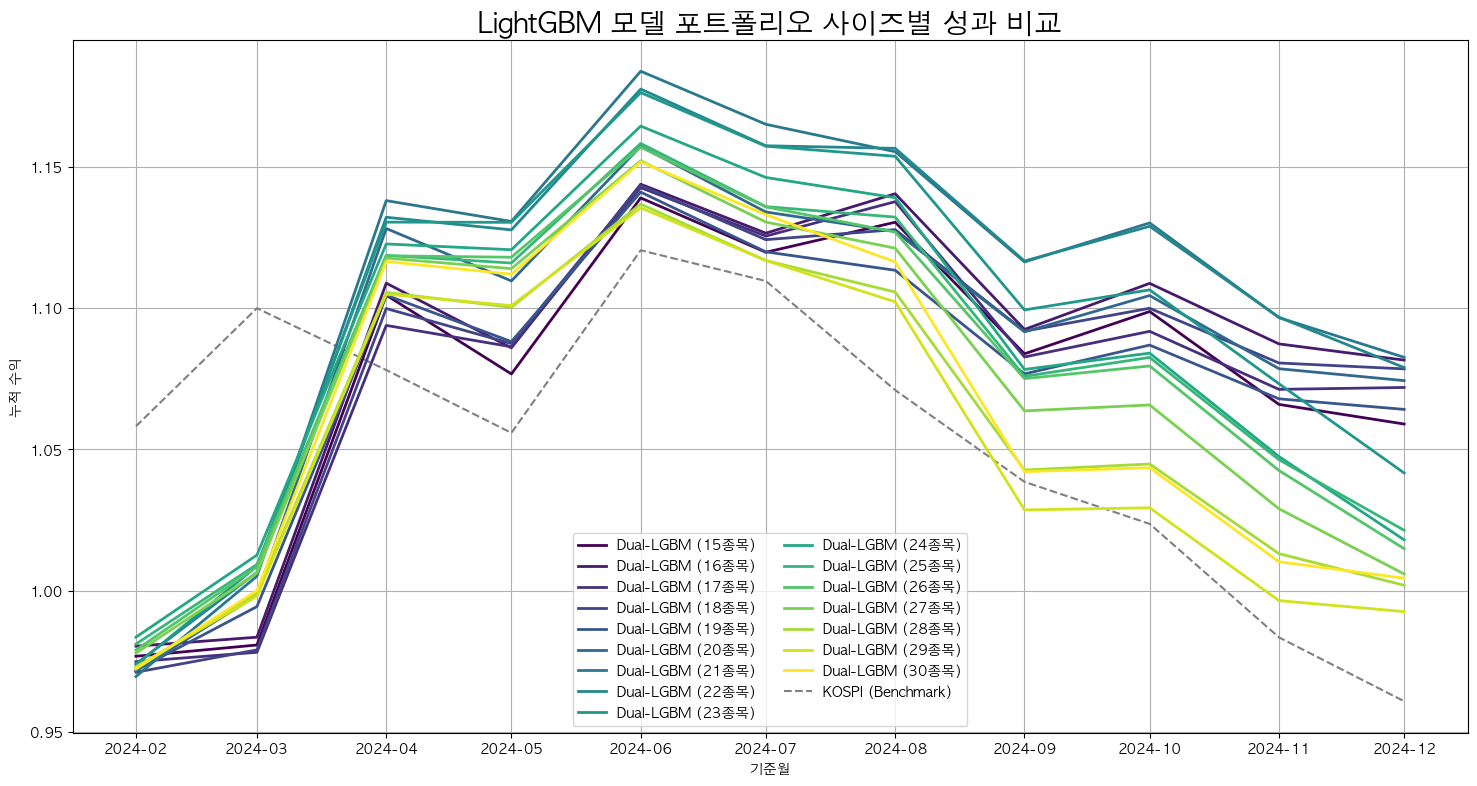

In [15]:
# 파일 이름: 02_run_lightgbm_comparison.py
# 역할: 미리 생성된 데이터셋을 불러와, LightGBM 모델을 사용하여
#       포트폴리오 사이즈(15~30개)별 성과를 비교 분석하는 최종 스크립트.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb # XGBoost -> LightGBM으로 변경
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib 한글 폰트 설정 ---
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        print("한글 폰트 설정에 실패했습니다. 기본 폰트로 설정됩니다.")
plt.rcParams['axes.unicode_minus'] = False

# --- 헬퍼 함수 ---
def get_kospi_data_for_caching(start_date, end_date):
    """(캐시 생성용) KOSPI 월별 수익률 데이터를 수집합니다."""
    print("KOSPI 벤치마크 데이터를 다운로드합니다...");
    safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last()
    kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'수익률': kospi_monthly_returns}).reset_index()
    kospi_df_monthly.rename(columns={'Date': '기준월'}, inplace=True)
    kospi_df_monthly['기준월'] = pd.to_datetime(kospi_df_monthly['기준월']).dt.to_period('M').dt.to_timestamp()
    print("✅ KOSPI 데이터 준비 완료!")
    return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    """성과 지표를 계산하는 헬퍼 함수"""
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- 최종 백테스터 클래스 ---
class DualMachineLearningBacktester:
    """알파 모델과 리스크 모델을 결합한 백테스터 클래스."""
    def __init__(self, ml_dataset, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_original = df_original
        self.top_n = top_n
        self.cost = cost

    def run_walk_forward_backtest(self, train_months=36, test_months=6):
        """확장 윈도우 방식으로 듀얼 LightGBM 모델을 학습하고 백테스트 수익률을 반환합니다."""
        print(f"듀얼 LightGBM 확장 윈도우 백테스트를 실행합니다 (종목 수: {self.top_n})...");
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['기준월'].unique())
        monthly_returns = []
        
        current_train_end_idx = train_months
        while current_train_end_idx < len(unique_dates):
            train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
            test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
            if test_start > test_end: break

            print(f"--- 학습: {train_start.strftime('%Y-%m')}~{train_end.strftime('%Y-%m')} | 검증: {test_start.strftime('%Y-%m')}~{test_end.strftime('%Y-%m')} ---")
            
            train_data = dataset[dataset['기준월'].between(train_start, train_end)]
            features = [col for col in dataset.columns if col not in ['기준월', '종목코드', 'y_alpha', 'y_risk']]
            X_train, y_alpha_train, y_risk_train = train_data[features], train_data['y_alpha'], train_data['y_risk']
            
            # 모델을 LightGBM으로 변경
            alpha_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); alpha_model.fit(X_train, y_alpha_train)
            risk_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); risk_model.fit(X_train, y_risk_train)

            for date in pd.date_range(test_start, test_end, freq='MS'):
                current_month_data = dataset[dataset['기준월'] == date].copy()
                if current_month_data.empty: continue
                X_test = current_month_data[features]
                
                current_month_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                candidate_stocks = current_month_data.nlargest(50, 'alpha_score') # 알파 모델이 50개 추천
                X_candidates = candidate_stocks[features]
                candidate_stocks['risk_score'] = risk_model.predict_proba(X_candidates)[:, 1]
                final_portfolio_stocks = candidate_stocks.nsmallest(self.top_n, 'risk_score')['종목코드'].tolist() # 리스크 모델이 최종 top_n개 선택
                
                next_month_date = date + pd.DateOffset(months=1)
                next_month_data_orig = self.df_original[self.df_original['기준월'] == next_month_date]
                next_month_returns = next_month_data_orig[next_month_data_orig['종목코드'].isin(final_portfolio_stocks)]
                monthly_return = (next_month_returns['1개월수익률'].mean() - self.cost) if not next_month_returns.empty else -self.cost
                monthly_returns.append({'기준월': next_month_date, '수익률': monthly_return})
            
            current_train_end_idx += test_months
        
        return pd.DataFrame(monthly_returns).set_index('기준월')['수익률']

# --- 메인 실행 블록 ---
if __name__ == '__main__':
    print("--- 최종 머신러닝 백테스팅 실행 시작 (LightGBM 포트폴리오 사이즈 비교) ---")
    try:
        # 1. 데이터 로드
        ml_dataset = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", parse_dates=['기준월'])
        df_original = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv", parse_dates=['기준월'])
        
        kospi_filepath = "/Users/gun/Desktop/경종설/퀀트/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['기준월'])
            print("✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.")
        except FileNotFoundError:
            print("⚠️ 저장된 KOSPI 데이터가 없어 새로 다운로드합니다.")
            start_date, end_date = df_original['기준월'].min(), df_original['기준월'].max()
            kospi_df = get_kospi_data_for_caching(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.")

        # 2. 비교할 파라미터 설정
        portfolio_sizes_to_test = list(range(15, 31)) # 15부터 30까지 모든 정수
        train_months = 36
        
        all_results = {}
        all_returns = {}

        # 3. 각 포트폴리오 사이즈별로 백테스트 실행
        for n_stocks in portfolio_sizes_to_test:
            print(f"\n" + "="*80); print(f"포트폴리오 종목 수: {n_stocks}개 테스트 시작"); print("="*80)
            
            backtester = DualMachineLearningBacktester(
                ml_dataset=ml_dataset, 
                df_original=df_original,
                top_n=n_stocks
            )
            returns = backtester.run_walk_forward_backtest(train_months=train_months, test_months=6)
            
            strategy_name = f'Dual-LGBM ({n_stocks}종목)' # 모델 이름 변경
            all_returns[strategy_name] = returns
            all_results[strategy_name] = calculate_performance_metrics(returns)

        # 4. 최종 결과 비교 출력
        print("\n" + "="*60); print(" " * 15 + "- 포트폴리오 사이즈별 최종 성과 비교 -"); print("="*60)
        summary_df = pd.DataFrame.from_dict(all_results, orient='index')
        for col in summary_df.columns:
            summary_df[col] = summary_df[col].apply(lambda x: f"{x:.2%}" if col != 'Sharpe Ratio' else f"{x:.2f}")
        print(summary_df); print("="*60)
        
        # 5. 최종 결과 시각화
        returns_df_all = pd.concat(all_returns, axis=1)
        cum_returns = (1 + returns_df_all.fillna(0)).cumprod()
        kospi_returns_aligned = kospi_df.set_index('기준월').loc[cum_returns.index]
        cum_returns_kospi = (1 + kospi_returns_aligned['수익률']).cumprod()
        
        plt.figure(figsize=(18, 9))
        plt.title('LightGBM 모델 포트폴리오 사이즈별 성과 비교', fontsize=20)
        
        colormap = plt.cm.viridis(np.linspace(0, 1, len(cum_returns.columns)))
        for i, name in enumerate(cum_returns.columns):
            plt.plot(cum_returns.index, cum_returns[name], label=name, color=colormap[i], lw=2, zorder=5)
            
        plt.plot(cum_returns_kospi.index, cum_returns_kospi, label='KOSPI (Benchmark)', color='grey', ls='--', zorder=4)
        plt.ylabel('누적 수익'); plt.xlabel('기준월'); plt.legend(ncol=2); plt.grid(True); plt.show()

    except FileNotFoundError as e:
        print(f"\n!!! 오류: {e} !!!"); print("먼저 '01_build_ultimate_dataset.py'를 실행하여 데이터 파일을 생성해주세요.")


--- 최종 머신러닝 백테스팅 실행 시작 (LightGBM 그리드 서치) ---
✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.
✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.

################################################################################
## 1차 후보군 사이즈: 50개 테스트 시작 ##
################################################################################


후보군 50개 진행률:   0%|          | 0/16 [00:00<?, ?it/s]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 15) ---


후보군 50개 진행률:   6%|▋         | 1/16 [00:02<00:30,  2.06s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 16) ---


후보군 50개 진행률:  12%|█▎        | 2/16 [00:04<00:28,  2.05s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 17) ---


후보군 50개 진행률:  19%|█▉        | 3/16 [00:06<00:26,  2.06s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 18) ---


후보군 50개 진행률:  25%|██▌       | 4/16 [00:08<00:25,  2.11s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 19) ---


후보군 50개 진행률:  31%|███▏      | 5/16 [00:10<00:23,  2.09s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 20) ---


후보군 50개 진행률:  38%|███▊      | 6/16 [00:12<00:20,  2.08s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 21) ---


후보군 50개 진행률:  44%|████▍     | 7/16 [00:14<00:18,  2.06s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 22) ---


후보군 50개 진행률:  50%|█████     | 8/16 [00:16<00:16,  2.06s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 23) ---


후보군 50개 진행률:  56%|█████▋    | 9/16 [00:18<00:14,  2.04s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 24) ---


후보군 50개 진행률:  62%|██████▎   | 10/16 [00:20<00:12,  2.01s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 25) ---


후보군 50개 진행률:  69%|██████▉   | 11/16 [00:22<00:09,  1.97s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 26) ---


후보군 50개 진행률:  75%|███████▌  | 12/16 [00:24<00:07,  1.95s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 27) ---


후보군 50개 진행률:  81%|████████▏ | 13/16 [00:26<00:05,  1.93s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 28) ---


후보군 50개 진행률:  88%|████████▊ | 14/16 [00:28<00:03,  1.92s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 29) ---


후보군 50개 진행률:  94%|█████████▍| 15/16 [00:29<00:01,  1.91s/it]

--- 백테스트 실행 (후보군: 50, 최종 종목 수: 30) ---


후보군 50개 진행률: 100%|██████████| 16/16 [00:31<00:00,  1.99s/it]



################################################################################
## 1차 후보군 사이즈: 100개 테스트 시작 ##
################################################################################


후보군 100개 진행률:   0%|          | 0/16 [00:00<?, ?it/s]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 15) ---


후보군 100개 진행률:   6%|▋         | 1/16 [00:01<00:29,  1.95s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 16) ---


후보군 100개 진행률:  12%|█▎        | 2/16 [00:03<00:26,  1.91s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 17) ---


후보군 100개 진행률:  19%|█▉        | 3/16 [00:05<00:24,  1.91s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 18) ---


후보군 100개 진행률:  25%|██▌       | 4/16 [00:07<00:22,  1.91s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 19) ---


후보군 100개 진행률:  31%|███▏      | 5/16 [00:09<00:20,  1.90s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 20) ---


후보군 100개 진행률:  38%|███▊      | 6/16 [00:11<00:18,  1.89s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 21) ---


후보군 100개 진행률:  44%|████▍     | 7/16 [00:13<00:17,  1.90s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 22) ---


후보군 100개 진행률:  50%|█████     | 8/16 [00:15<00:15,  1.90s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 23) ---


후보군 100개 진행률:  56%|█████▋    | 9/16 [00:17<00:13,  1.90s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 24) ---


후보군 100개 진행률:  62%|██████▎   | 10/16 [00:19<00:11,  1.91s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 25) ---


후보군 100개 진행률:  69%|██████▉   | 11/16 [00:20<00:09,  1.91s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 26) ---


후보군 100개 진행률:  75%|███████▌  | 12/16 [00:22<00:07,  1.90s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 27) ---


후보군 100개 진행률:  81%|████████▏ | 13/16 [00:24<00:05,  1.90s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 28) ---


후보군 100개 진행률:  88%|████████▊ | 14/16 [00:26<00:03,  1.90s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 29) ---


후보군 100개 진행률:  94%|█████████▍| 15/16 [00:28<00:01,  1.90s/it]

--- 백테스트 실행 (후보군: 100, 최종 종목 수: 30) ---


후보군 100개 진행률: 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]



################################################################################
## 1차 후보군 사이즈: 150개 테스트 시작 ##
################################################################################


후보군 150개 진행률:   0%|          | 0/16 [00:00<?, ?it/s]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 15) ---


후보군 150개 진행률:   6%|▋         | 1/16 [00:01<00:29,  1.94s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 16) ---


후보군 150개 진행률:  12%|█▎        | 2/16 [00:03<00:26,  1.91s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 17) ---


후보군 150개 진행률:  19%|█▉        | 3/16 [00:05<00:24,  1.92s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 18) ---


후보군 150개 진행률:  25%|██▌       | 4/16 [00:07<00:22,  1.91s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 19) ---


후보군 150개 진행률:  31%|███▏      | 5/16 [00:09<00:20,  1.89s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 20) ---


후보군 150개 진행률:  38%|███▊      | 6/16 [00:11<00:18,  1.89s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 21) ---


후보군 150개 진행률:  44%|████▍     | 7/16 [00:13<00:17,  1.90s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 22) ---


후보군 150개 진행률:  50%|█████     | 8/16 [00:15<00:15,  1.90s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 23) ---


후보군 150개 진행률:  56%|█████▋    | 9/16 [00:17<00:13,  1.90s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 24) ---


후보군 150개 진행률:  62%|██████▎   | 10/16 [00:18<00:11,  1.89s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 25) ---


후보군 150개 진행률:  69%|██████▉   | 11/16 [00:20<00:09,  1.89s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 26) ---


후보군 150개 진행률:  75%|███████▌  | 12/16 [00:22<00:07,  1.90s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 27) ---


후보군 150개 진행률:  81%|████████▏ | 13/16 [00:24<00:05,  1.90s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 28) ---


후보군 150개 진행률:  88%|████████▊ | 14/16 [00:26<00:03,  1.90s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 29) ---


후보군 150개 진행률:  94%|█████████▍| 15/16 [00:28<00:01,  1.90s/it]

--- 백테스트 실행 (후보군: 150, 최종 종목 수: 30) ---


후보군 150개 진행률: 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]



################################################################################
## 1차 후보군 사이즈: 200개 테스트 시작 ##
################################################################################


후보군 200개 진행률:   0%|          | 0/16 [00:00<?, ?it/s]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 15) ---


후보군 200개 진행률:   6%|▋         | 1/16 [00:01<00:28,  1.89s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 16) ---


후보군 200개 진행률:  12%|█▎        | 2/16 [00:03<00:26,  1.89s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 17) ---


후보군 200개 진행률:  19%|█▉        | 3/16 [00:05<00:24,  1.89s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 18) ---


후보군 200개 진행률:  25%|██▌       | 4/16 [00:07<00:22,  1.88s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 19) ---


후보군 200개 진행률:  31%|███▏      | 5/16 [00:09<00:20,  1.89s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 20) ---


후보군 200개 진행률:  38%|███▊      | 6/16 [00:11<00:18,  1.89s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 21) ---


후보군 200개 진행률:  44%|████▍     | 7/16 [00:13<00:16,  1.89s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 22) ---


후보군 200개 진행률:  50%|█████     | 8/16 [00:15<00:15,  1.89s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 23) ---


후보군 200개 진행률:  56%|█████▋    | 9/16 [00:16<00:13,  1.89s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 24) ---


후보군 200개 진행률:  62%|██████▎   | 10/16 [00:18<00:11,  1.88s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 25) ---


후보군 200개 진행률:  69%|██████▉   | 11/16 [00:20<00:09,  1.88s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 26) ---


후보군 200개 진행률:  75%|███████▌  | 12/16 [00:22<00:07,  1.89s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 27) ---


후보군 200개 진행률:  81%|████████▏ | 13/16 [00:24<00:05,  1.89s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 28) ---


후보군 200개 진행률:  88%|████████▊ | 14/16 [00:26<00:03,  1.90s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 29) ---


후보군 200개 진행률:  94%|█████████▍| 15/16 [00:28<00:01,  1.90s/it]

--- 백테스트 실행 (후보군: 200, 최종 종목 수: 30) ---


후보군 200개 진행률: 100%|██████████| 16/16 [00:30<00:00,  1.89s/it]



################################################################################
## 1차 후보군 사이즈: 250개 테스트 시작 ##
################################################################################


후보군 250개 진행률:   0%|          | 0/16 [00:00<?, ?it/s]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 15) ---


후보군 250개 진행률:   6%|▋         | 1/16 [00:01<00:28,  1.90s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 16) ---


후보군 250개 진행률:  12%|█▎        | 2/16 [00:03<00:26,  1.89s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 17) ---


후보군 250개 진행률:  19%|█▉        | 3/16 [00:05<00:24,  1.89s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 18) ---


후보군 250개 진행률:  25%|██▌       | 4/16 [00:07<00:22,  1.89s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 19) ---


후보군 250개 진행률:  31%|███▏      | 5/16 [00:09<00:20,  1.88s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 20) ---


후보군 250개 진행률:  38%|███▊      | 6/16 [00:11<00:18,  1.88s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 21) ---


후보군 250개 진행률:  44%|████▍     | 7/16 [00:13<00:17,  1.89s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 22) ---


후보군 250개 진행률:  50%|█████     | 8/16 [00:15<00:15,  1.89s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 23) ---


후보군 250개 진행률:  56%|█████▋    | 9/16 [00:17<00:13,  1.89s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 24) ---


후보군 250개 진행률:  62%|██████▎   | 10/16 [00:18<00:11,  1.89s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 25) ---


후보군 250개 진행률:  69%|██████▉   | 11/16 [00:20<00:09,  1.89s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 26) ---


후보군 250개 진행률:  75%|███████▌  | 12/16 [00:22<00:07,  1.89s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 27) ---


후보군 250개 진행률:  81%|████████▏ | 13/16 [00:24<00:05,  1.90s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 28) ---


후보군 250개 진행률:  88%|████████▊ | 14/16 [00:26<00:03,  1.90s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 29) ---


후보군 250개 진행률:  94%|█████████▍| 15/16 [00:28<00:01,  1.90s/it]

--- 백테스트 실행 (후보군: 250, 최종 종목 수: 30) ---


후보군 250개 진행률: 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]



################################################################################
## 1차 후보군 사이즈: 300개 테스트 시작 ##
################################################################################


후보군 300개 진행률:   0%|          | 0/16 [00:00<?, ?it/s]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 15) ---


후보군 300개 진행률:   6%|▋         | 1/16 [00:01<00:28,  1.90s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 16) ---


후보군 300개 진행률:  12%|█▎        | 2/16 [00:03<00:26,  1.90s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 17) ---


후보군 300개 진행률:  19%|█▉        | 3/16 [00:05<00:24,  1.90s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 18) ---


후보군 300개 진행률:  25%|██▌       | 4/16 [00:07<00:22,  1.89s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 19) ---


후보군 300개 진행률:  31%|███▏      | 5/16 [00:09<00:20,  1.90s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 20) ---


후보군 300개 진행률:  38%|███▊      | 6/16 [00:11<00:18,  1.90s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 21) ---


후보군 300개 진행률:  44%|████▍     | 7/16 [00:13<00:17,  1.90s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 22) ---


후보군 300개 진행률:  50%|█████     | 8/16 [00:15<00:15,  1.90s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 23) ---


후보군 300개 진행률:  56%|█████▋    | 9/16 [00:17<00:13,  1.91s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 24) ---


후보군 300개 진행률:  62%|██████▎   | 10/16 [00:19<00:11,  1.91s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 25) ---


후보군 300개 진행률:  69%|██████▉   | 11/16 [00:20<00:09,  1.91s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 26) ---


후보군 300개 진행률:  75%|███████▌  | 12/16 [00:22<00:07,  1.91s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 27) ---


후보군 300개 진행률:  81%|████████▏ | 13/16 [00:24<00:05,  1.90s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 28) ---


후보군 300개 진행률:  88%|████████▊ | 14/16 [00:26<00:03,  1.91s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 29) ---


후보군 300개 진행률:  94%|█████████▍| 15/16 [00:28<00:01,  1.90s/it]

--- 백테스트 실행 (후보군: 300, 최종 종목 수: 30) ---


후보군 300개 진행률: 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


               🏆 Sharpe Ratio 기준 상위 10개 우수 조합 🏆
              CAGR     MDD Volatility Sharpe Ratio
후보군200_최종25  8.04%  -4.59%     11.24%         0.71
후보군200_최종24  7.38%  -5.10%     11.02%         0.67
후보군200_최종26  6.51%  -4.47%     11.07%         0.59
후보군50_최종18   8.59%  -5.67%     15.45%         0.56
후보군50_최종16   8.93%  -5.44%     16.22%         0.55
후보군50_최종22   8.64%  -8.37%     15.99%         0.54
후보군50_최종21   9.04%  -8.55%     16.93%         0.53
후보군50_최종17   7.87%  -6.25%     15.44%         0.51
후보군50_최종20   8.14%  -7.16%     16.28%         0.50
후보군50_최종19   7.02%  -6.74%     14.53%         0.48


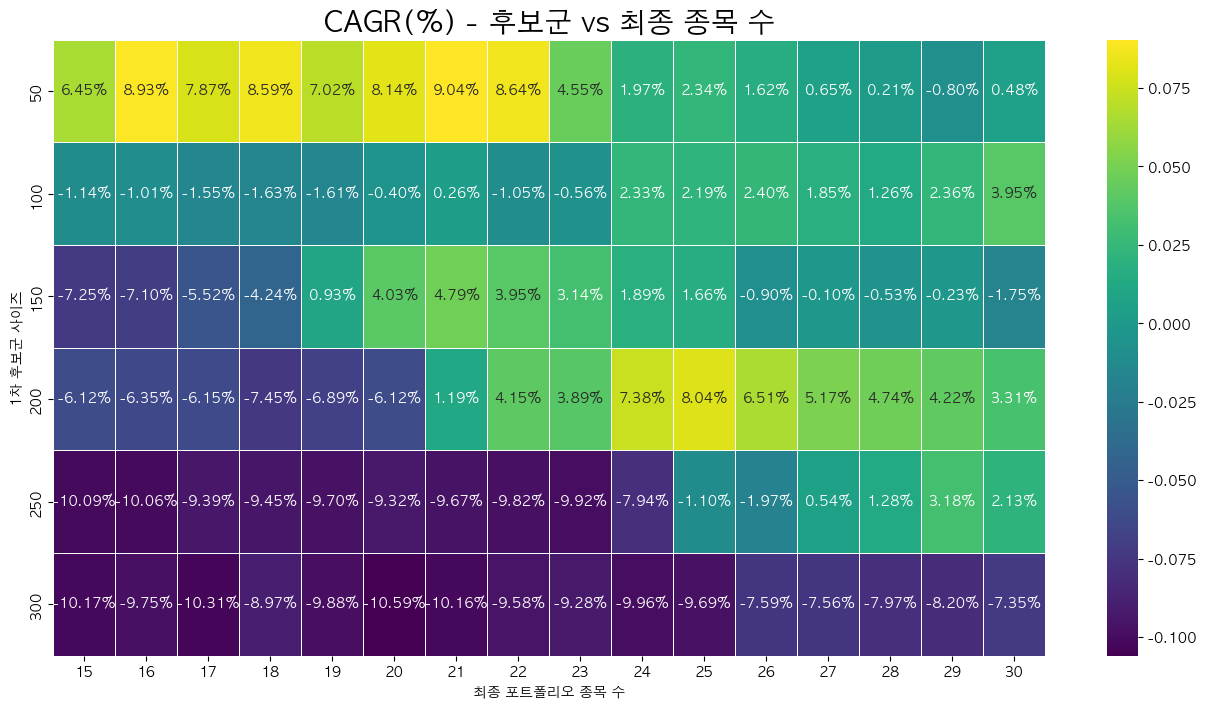

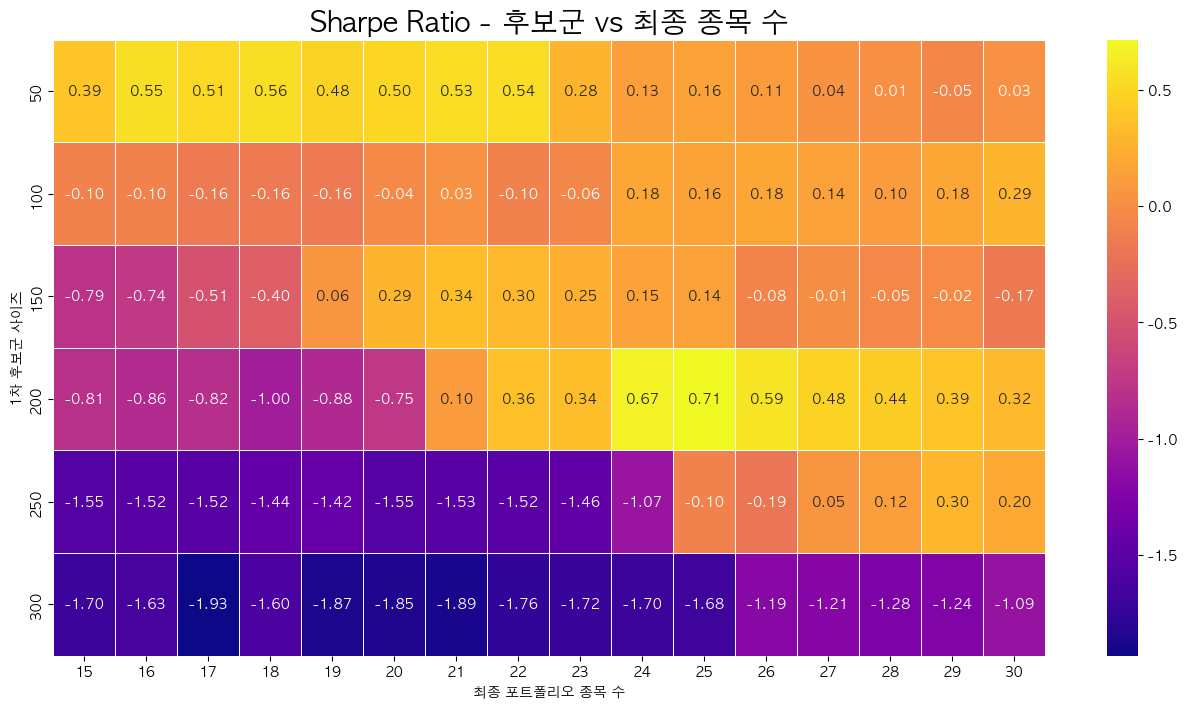

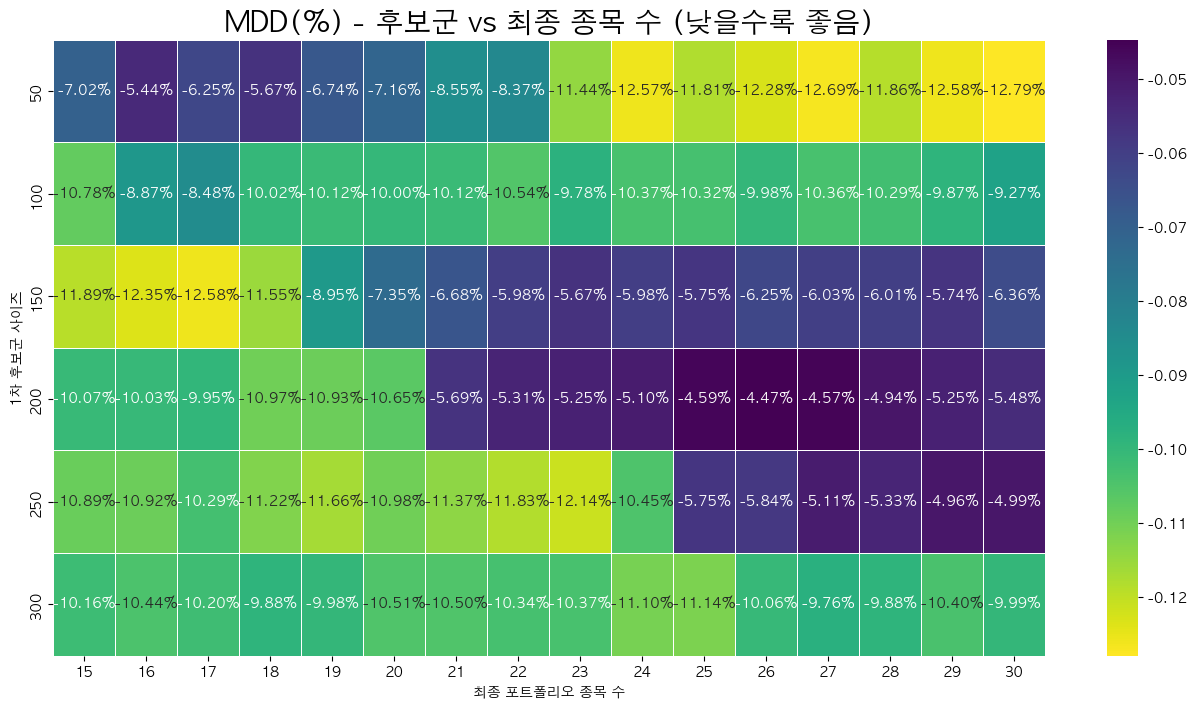

In [8]:
# 파일 이름: 02_run_lightgbm_grid_search_final.py
# 역할: LightGBM 모델 그리드 서치를 수행하고, 샤프 지수 기준 상위 10개 조합을 추출하며,
#       CAGR, Sharpe Ratio, MDD를 히트맵으로 시각화하는 최종 스크립트.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib 한글 폰트 설정 ---
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        print("한글 폰트 설정에 실패했습니다. 기본 폰트로 설정됩니다.")
plt.rcParams['axes.unicode_minus'] = False

# --- 헬퍼 함수 ---
def get_kospi_data_for_caching(start_date, end_date):
    """(캐시 생성용) KOSPI 월별 수익률 데이터를 수집합니다."""
    print("KOSPI 벤치마크 데이터를 다운로드합니다...");
    safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last()
    kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'수익률': kospi_monthly_returns}).reset_index()
    kospi_df_monthly.rename(columns={'Date': '기준월'}, inplace=True)
    kospi_df_monthly['기준월'] = pd.to_datetime(kospi_df_monthly['기준월']).dt.to_period('M').dt.to_timestamp()
    print("✅ KOSPI 데이터 준비 완료!")
    return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    """성과 지표를 계산하는 헬퍼 함수"""
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- 최종 백테스터 클래스 ---
class DualMachineLearningBacktester:
    """알파 모델과 리스크 모델을 결합한 백테스터 클래스."""
    def __init__(self, ml_dataset, df_original, top_n=20, candidate_pool_size=50, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_original = df_original
        self.top_n = top_n
        self.candidate_pool_size = candidate_pool_size
        self.cost = cost

    def run_walk_forward_backtest(self, train_months=36, test_months=6):
        """확장 윈도우 방식으로 듀얼 LightGBM 모델을 학습하고 백테스트 수익률을 반환합니다."""
        print(f"--- 백테스트 실행 (후보군: {self.candidate_pool_size}, 최종 종목 수: {self.top_n}) ---")
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['기준월'].unique())
        monthly_returns = []
        
        current_train_end_idx = train_months
        while current_train_end_idx < len(unique_dates):
            train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
            test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
            if test_start > test_end: break

            train_data = dataset[dataset['기준월'].between(train_start, train_end)]
            features = [col for col in dataset.columns if col not in ['기준월', '종목코드', 'y_alpha', 'y_risk']]
            X_train, y_alpha_train, y_risk_train = train_data[features], train_data['y_alpha'], train_data['y_risk']
            
            alpha_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); alpha_model.fit(X_train, y_alpha_train)
            risk_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); risk_model.fit(X_train, y_risk_train)

            for date in pd.date_range(test_start, test_end, freq='MS'):
                current_month_data = dataset[dataset['기준월'] == date].copy()
                if current_month_data.empty: continue
                X_test = current_month_data[features]
                
                current_month_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                candidate_stocks = current_month_data.nlargest(self.candidate_pool_size, 'alpha_score')
                X_candidates = candidate_stocks[features]
                candidate_stocks['risk_score'] = risk_model.predict_proba(X_candidates)[:, 1]
                final_portfolio_stocks = candidate_stocks.nsmallest(self.top_n, 'risk_score')['종목코드'].tolist()
                
                next_month_date = date + pd.DateOffset(months=1)
                next_month_data_orig = self.df_original[self.df_original['기준월'] == next_month_date]
                next_month_returns = next_month_data_orig[next_month_data_orig['종목코드'].isin(final_portfolio_stocks)]
                monthly_return = (next_month_returns['1개월수익률'].mean() - self.cost) if not next_month_returns.empty else -self.cost
                monthly_returns.append({'기준월': next_month_date, '수익률': monthly_return})
            
            current_train_end_idx += test_months
        
        return pd.DataFrame(monthly_returns).set_index('기준월')['수익률']

# --- 메인 실행 블록 ---
if __name__ == '__main__':
    print("--- 최종 머신러닝 백테스팅 실행 시작 (LightGBM 그리드 서치) ---")
    try:
        # 1. 데이터 로드
        ml_dataset = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", parse_dates=['기준월'])
        df_original = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv", parse_dates=['기준월'])
        
        kospi_filepath = "/Users/gun/Desktop/경종설/퀀트/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['기준월'])
            print("✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.")
        except FileNotFoundError:
            print("⚠️ 저장된 KOSPI 데이터가 없어 새로 다운로드합니다.")
            start_date, end_date = df_original['기준월'].min(), df_original['기준월'].max()
            kospi_df = get_kospi_data_for_caching(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.")

        # 2. 그리드 서치를 위한 파라미터 설정
        candidate_pool_sizes = [50, 100, 150, 200, 250, 300]
        portfolio_sizes_to_test = list(range(15, 31))
        train_months = 36
        
        all_results = {}
        
        # 3. 이중 반복문을 사용한 그리드 서치 실행
        for pool_size in candidate_pool_sizes:
            print(f"\n" + "#"*80)
            print(f"## 1차 후보군 사이즈: {pool_size}개 테스트 시작 ##")
            print("#"*80)

            for n_stocks in tqdm(portfolio_sizes_to_test, desc=f"후보군 {pool_size}개 진행률"):
                if n_stocks >= pool_size: continue

                backtester = DualMachineLearningBacktester(
                    ml_dataset=ml_dataset, 
                    df_original=df_original,
                    top_n=n_stocks,
                    candidate_pool_size=pool_size
                )
                returns = backtester.run_walk_forward_backtest(train_months=train_months, test_months=6)
                
                strategy_name = f'후보군{pool_size}_최종{n_stocks}'
                all_results[strategy_name] = calculate_performance_metrics(returns)

        # 4. 최종 결과 요약 및 우수 조합 추출
        summary_df = pd.DataFrame.from_dict(all_results, orient='index')

        # ### 추가된 부분 ###: Sharpe Ratio 기준 상위 10개 우수 조합 추출 및 출력
        print("\n" + "="*70)
        print(" " * 15 + "🏆 Sharpe Ratio 기준 상위 10개 우수 조합 🏆")
        print("="*70)
        
        top_10_df = summary_df.sort_values(by='Sharpe Ratio', ascending=False).head(10).copy()
        
        # 보기 좋게 포맷팅
        top_10_df['CAGR'] = top_10_df['CAGR'].apply(lambda x: f"{x:.2%}")
        top_10_df['MDD'] = top_10_df['MDD'].apply(lambda x: f"{x:.2%}")
        top_10_df['Volatility'] = top_10_df['Volatility'].apply(lambda x: f"{x:.2%}")
        top_10_df['Sharpe Ratio'] = top_10_df['Sharpe Ratio'].apply(lambda x: f"{x:.2f}")
        
        print(top_10_df)
        print("="*70)
        
        
        # 5. 최종 결과 히트맵 시각화
        summary_df['후보군'] = summary_df.index.map(lambda x: int(x.split('_')[0].replace('후보군','')))
        summary_df['최종종목수'] = summary_df.index.map(lambda x: int(x.split('_')[1].replace('최종','')))
        
        # 연평균복리수익률(CAGR) 히트맵
        cagr_pivot = summary_df.pivot(index='후보군', columns='최종종목수', values='CAGR')
        plt.figure(figsize=(16, 8))
        sns.heatmap(cagr_pivot, annot=True, fmt='.2%', cmap='viridis', linewidths=.5)
        plt.title('CAGR(%) - 후보군 vs 최종 종목 수', fontsize=20)
        plt.xlabel('최종 포트폴리오 종목 수')
        plt.ylabel('1차 후보군 사이즈')
        plt.show()

        # 샤프 비율(Sharpe Ratio) 히트맵
        sharpe_pivot = summary_df.pivot(index='후보군', columns='최종종목수', values='Sharpe Ratio')
        plt.figure(figsize=(16, 8))
        sns.heatmap(sharpe_pivot, annot=True, fmt='.2f', cmap='plasma', linewidths=.5)
        plt.title('Sharpe Ratio - 후보군 vs 최종 종목 수', fontsize=20)
        plt.xlabel('최종 포트폴리오 종목 수')
        plt.ylabel('1차 후보군 사이즈')
        plt.show()
        
        # ### 추가된 부분 ###: 최대 낙폭(MDD) 히트맵
        # MDD는 낮을수록 좋으므로, 색상맵을 반전(_r)하여 어두운 색이 좋은(낮은) 값을 나타내게 함
        mdd_pivot = summary_df.pivot(index='후보군', columns='최종종목수', values='MDD')
        plt.figure(figsize=(16, 8))
        sns.heatmap(mdd_pivot, annot=True, fmt='.2%', cmap='viridis_r', linewidths=.5)
        plt.title('MDD(%) - 후보군 vs 최종 종목 수 (낮을수록 좋음)', fontsize=20)
        plt.xlabel('최종 포트폴리오 종목 수')
        plt.ylabel('1차 후보군 사이즈')
        plt.show()

    except FileNotFoundError as e:
        print(f"\n!!! 오류: {e} !!!"); print("먼저 '01_build_ultimate_dataset.py'를 실행하여 데이터 파일을 생성해주세요.")
    except Exception as e:
        print(f"\n!!! 예상치 못한 오류가 발생했습니다: {e} !!!")

--- 최종 머신러닝 백테스팅 실행 시작 (Feature Importance 분석 포함) ---
✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.
✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.
듀얼 머신러닝 Walk-Forward 백테스트를 실행합니다 (최종 종목 수: 25)...


백테스트 진행률: 12it [00:01,  6.28it/s]                       


✅ 백테스트 완료!

            - 후보군200_최종25 전략 최종 성과 -
             후보군200_최종25
CAGR               8.04%
MDD               -4.59%
Volatility        11.24%
Sharpe Ratio        0.71


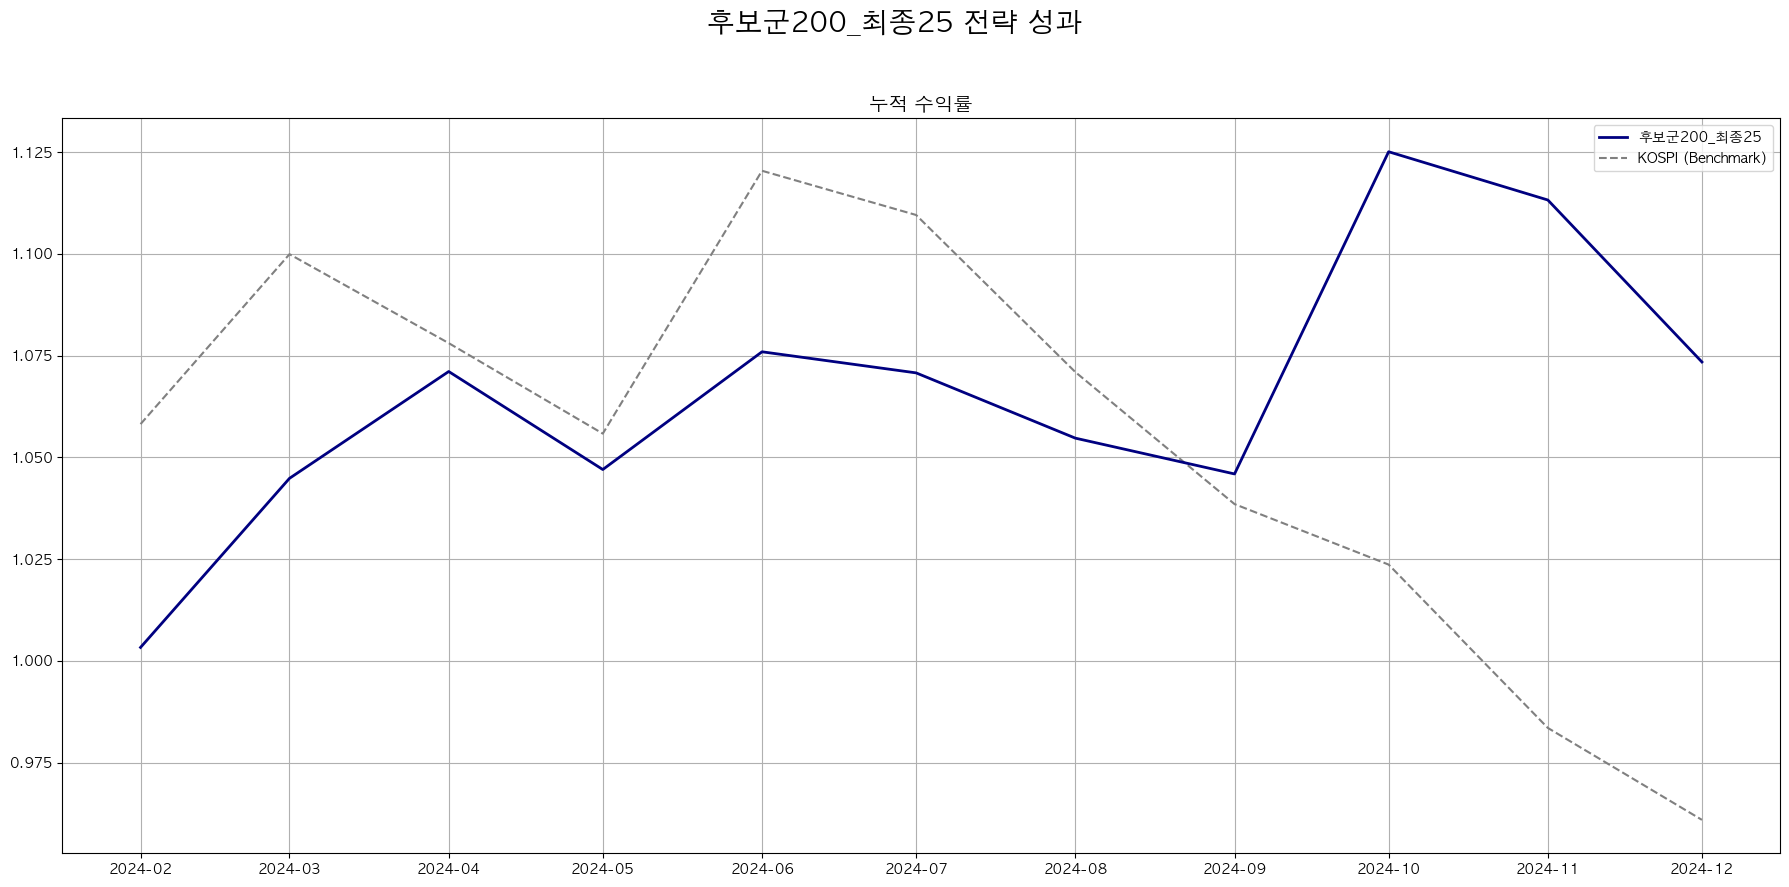

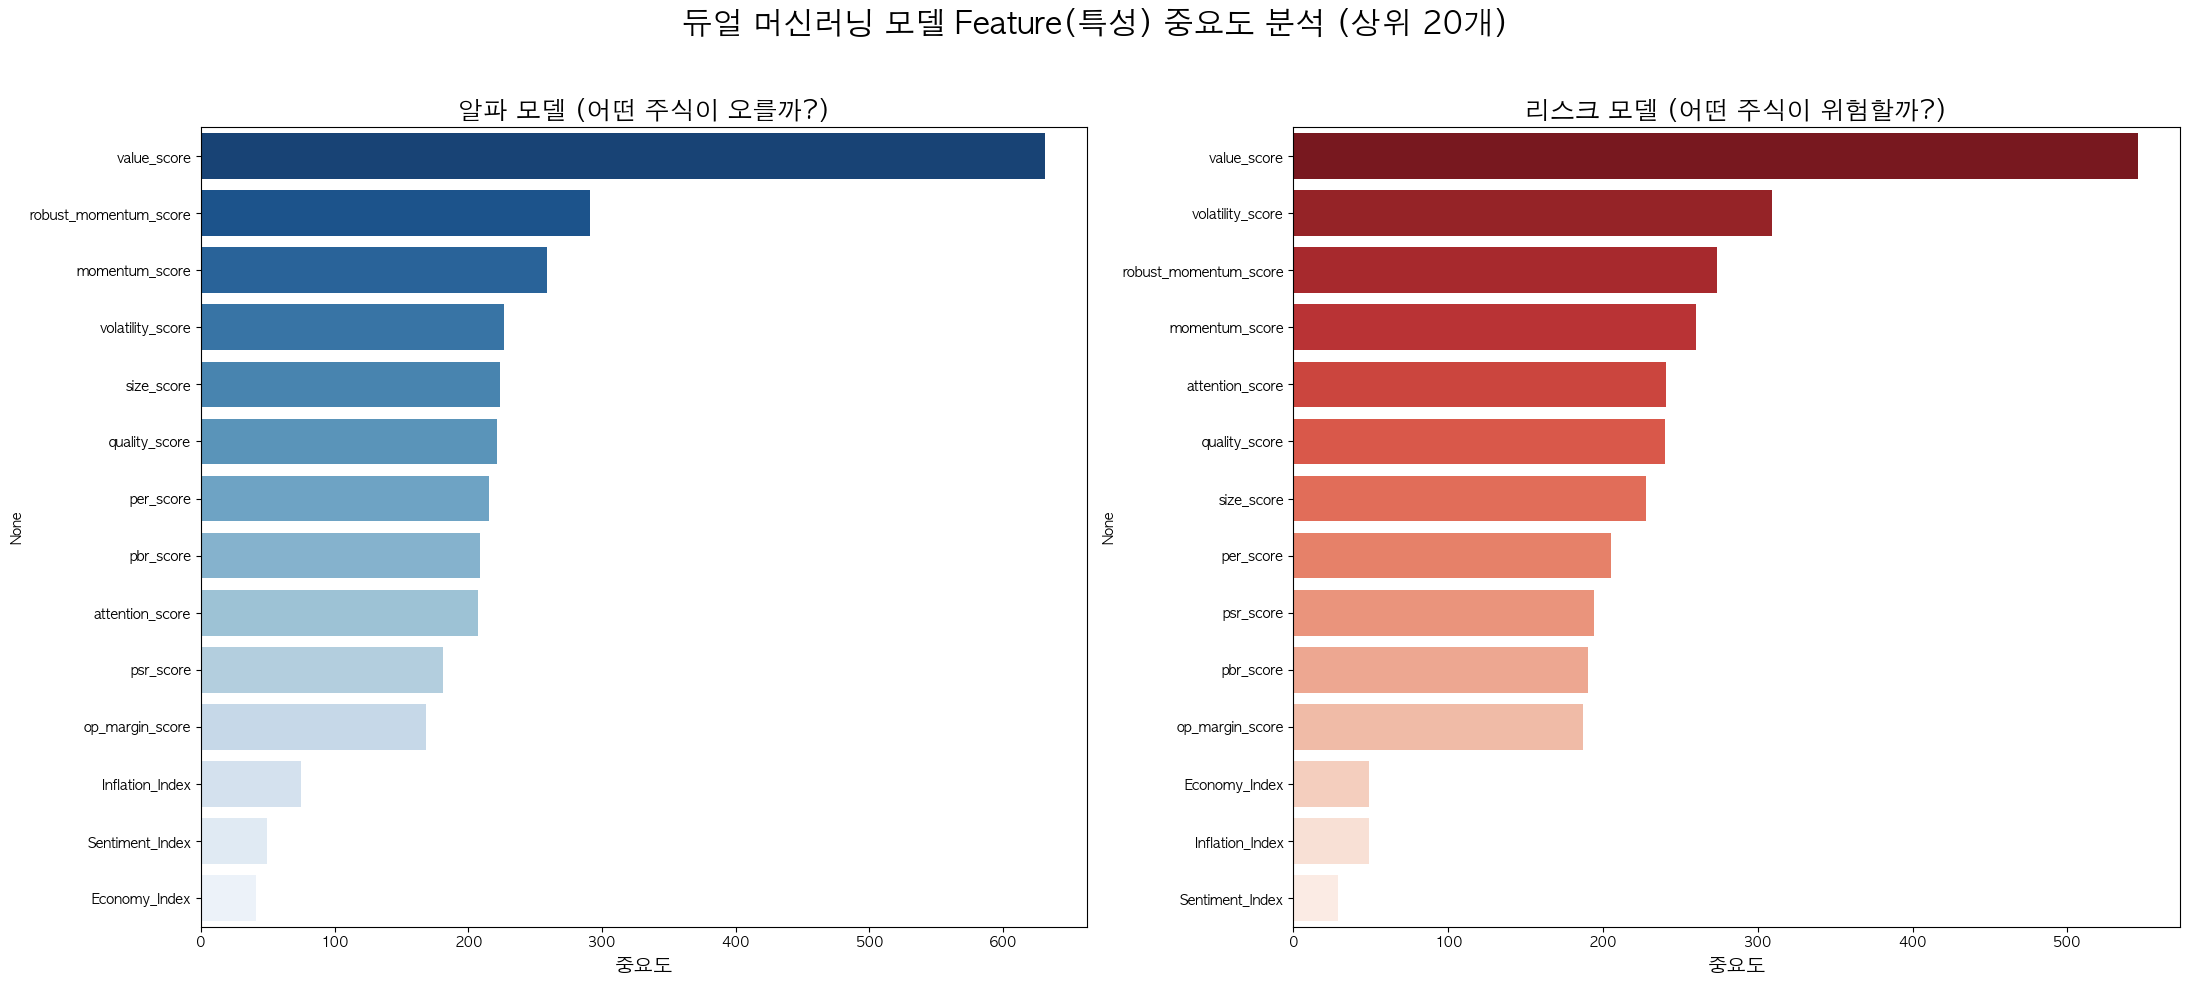

--- 최종 머신러닝 백테스팅 실행 시작 (Feature Importance 분석 포함) ---
✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.
✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.
듀얼 머신러닝 Walk-Forward 백테스트를 실행합니다 (최종 종목 수: 25)...


백테스트 진행률: 12it [00:01,  6.53it/s]                       


✅ 백테스트 완료!

!!! 예상치 못한 오류가 발생했습니다: 'DualMachineLearningBacktester' object has no attribute 'print_performance_summary' !!!


In [9]:
# 파일 이름: 02_run_backtest_with_feature_importance.py
# 역할: 최종 듀얼 ML 백테스트를 실행하고, 추가적으로
#       알파/리스크 모델이 어떤 Feature를 중요하게 생각했는지 분석하고 시각화.
# 수정 사항: 그리드 서치 최적 조합(후보군 200, 최종 25) 반영

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings
import seaborn as sns


warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib 한글 폰트 설정 ---
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        print("한글 폰트 설정에 실패했습니다. 기본 폰트로 설정됩니다.")
plt.rcParams['axes.unicode_minus'] = False

# --- 헬퍼 함수 ---
def get_kospi_data_for_caching(start_date, end_date):
    print("KOSPI 벤치마크 데이터를 다운로드합니다..."); safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last()
    kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'수익률': kospi_monthly_returns}).reset_index()
    kospi_df_monthly.rename(columns={'Date': '기준월'}, inplace=True)
    kospi_df_monthly['기준월'] = pd.to_datetime(kospi_df_monthly['기준월']).dt.to_period('M').dt.to_timestamp()
    print("✅ KOSPI 데이터 준비 완료!"); return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- 최종 백테스터 클래스 ---
class DualMachineLearningBacktester:
    def __init__(self, ml_dataset, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_original = df_original
        self.top_n = top_n
        self.cost = cost
        # 특성 중요도를 저장하기 위한 리스트 초기화
        self.alpha_feature_importances = []
        self.risk_feature_importances = []
        self.feature_names = []

    def run_walk_forward_backtest(self, train_months=36, test_months=6):
        print(f"듀얼 머신러닝 Walk-Forward 백테스트를 실행합니다 (최종 종목 수: {self.top_n})...");
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['기준월'].unique())
        monthly_returns = []
        
        current_train_end_idx = train_months
        # tqdm을 사용하여 진행 상황 표시
        with tqdm(total=len(unique_dates) - train_months, desc="백테스트 진행률") as pbar:
            while current_train_end_idx < len(unique_dates):
                train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
                test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
                if test_start > test_end: break
                
                train_data = dataset[dataset['기준월'].between(train_start, train_end)]
                self.feature_names = [col for col in dataset.columns if col not in ['기준월', '종목코드', 'y_alpha', 'y_risk']]
                X_train, y_alpha_train, y_risk_train = train_data[self.feature_names], train_data['y_alpha'], train_data['y_risk']
                
                # --- 모델 학습 및 특성 중요도 저장 ---
                alpha_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); alpha_model.fit(X_train, y_alpha_train)
                self.alpha_feature_importances.append(alpha_model.feature_importances_)
                
                risk_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); risk_model.fit(X_train, y_risk_train)
                self.risk_feature_importances.append(risk_model.feature_importances_)

                # --- 테스트 기간 예측 ---
                # 테스트 기간 전체에 대해 한 번에 예측 수행
                test_period_data = dataset[dataset['기준월'].between(test_start, test_end)].copy()
                if not test_period_data.empty:
                    X_test = test_period_data[self.feature_names]
                    test_period_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                    test_period_data['risk_score'] = risk_model.predict_proba(X_test)[:, 1]

                for date in pd.date_range(test_start, test_end, freq='MS'):
                    current_month_pred = test_period_data[test_period_data['기준월'] == date]
                    if current_month_pred.empty: continue
                    
                    # ### 수정된 부분 ###: 1차 후보군을 200개로 고정
                    candidate_stocks = current_month_pred.nlargest(200, 'alpha_score')
                    final_portfolio_stocks = candidate_stocks.nsmallest(self.top_n, 'risk_score')['종목코드'].tolist()
                    
                    next_month_date = date + pd.DateOffset(months=1)
                    next_month_data_orig = self.df_original[self.df_original['기준월'] == next_month_date]
                    next_month_returns = next_month_data_orig[next_month_data_orig['종목코드'].isin(final_portfolio_stocks)]
                    monthly_return = (next_month_returns['1개월수익률'].mean() - self.cost) if not next_month_returns.empty else -self.cost
                    monthly_returns.append({'기준월': next_month_date, '수익률': monthly_return})
                
                pbar.update(test_months)
                current_train_end_idx += test_months
        
        print("\n✅ 백테스트 완료!");
        self.returns_df = pd.DataFrame(monthly_returns).set_index('기준월')
        performance = calculate_performance_metrics(self.returns_df['수익률'].dropna())
        self.performance_summary = pd.DataFrame(performance, index=[f'후보군200_최종{self.top_n}']).T
        self.print_performance_summary()
    
    def display_feature_importances(self):
        """알파/리스크 모델의 평균 특성 중요도를 계산하고 시각화합니다."""
        if not self.alpha_feature_importances or not self.risk_feature_importances:
            print("특성 중요도 데이터가 없습니다.")
            return

        # 알파 모델 중요도 (상위 20개)
        alpha_imp = pd.DataFrame(self.alpha_feature_importances, columns=self.feature_names).mean().nlargest(20)
        # 리스크 모델 중요도 (상위 20개)
        risk_imp = pd.DataFrame(self.risk_feature_importances, columns=self.feature_names).mean().nlargest(20)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
        fig.suptitle('듀얼 머신러닝 모델 Feature(특성) 중요도 분석 (상위 20개)', fontsize=22)

        sns.barplot(x=alpha_imp.values, y=alpha_imp.index, ax=ax1, palette='Blues_r')
        ax1.set_title('알파 모델 (어떤 주식이 오를까?)', fontsize=18)
        ax1.set_xlabel('중요도', fontsize=14)

        sns.barplot(x=risk_imp.values, y=risk_imp.index, ax=ax2, palette='Reds_r')
        ax2.set_title('리스크 모델 (어떤 주식이 위험할까?)', fontsize=18)
        ax2.set_xlabel('중요도', fontsize=14)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    def print_performance_summary(self):
        print("\n" + "="*60); print(" " * 12 + f"- {self.performance_summary.columns[0]} 전략 최종 성과 -"); print("="*60)
        summary_df = self.performance_summary.copy();
        summary_df.iloc[0,0] = f"{summary_df.iloc[0,0]:.2%}" # CAGR
        summary_df.iloc[1,0] = f"{summary_df.iloc[1,0]:.2%}" # MDD
        summary_df.iloc[2,0] = f"{summary_df.iloc[2,0]:.2%}" # Volatility
        summary_df.iloc[3,0] = f"{summary_df.iloc[3,0]:.2f}" # Sharpe Ratio
        print(summary_df); print("="*60)

    def plot_results(self, kospi_df):
        if self.returns_df is None or self.returns_df.empty: return
        fig, ax1 = plt.subplots(1, 1, figsize=(18, 9)); fig.suptitle(f'{self.performance_summary.columns[0]} 전략 성과', fontsize=20)
        cum_returns = (1 + self.returns_df['수익률'].fillna(0)).cumprod()
        kospi_returns_aligned = kospi_df.set_index('기준월').loc[cum_returns.index]
        cum_returns_kospi = (1 + kospi_returns_aligned['수익률']).cumprod()
        ax1.plot(cum_returns.index, cum_returns, label=self.performance_summary.columns[0], color='navy', lw=2, zorder=5)
        ax1.plot(cum_returns_kospi.index, cum_returns_kospi, label='KOSPI (Benchmark)', color='grey', ls='--', zorder=4)
        ax1.set_title('누적 수익률', fontsize=14); ax1.legend(); ax1.grid(True); plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

# --- 메인 실행 블록 ---
if __name__ == '__main__':
    print("--- 최종 머신러닝 백테스팅 실행 시작 (Feature Importance 분석 포함) ---")
    try:
        # 1. 데이터 로드
        ml_dataset = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", parse_dates=['기준월'])
        df_original = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv", parse_dates=['기준월'])
        
        kospi_filepath = "/Users/gun/Desktop/경종설/퀀트/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['기준월'])
            print("✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.")
        except FileNotFoundError:
            print("⚠️ 저장된 KOSPI 데이터가 없어 새로 다운로드합니다.")
            start_date, end_date = df_original['기준월'].min(), df_original['기준월'].max()
            kospi_df = get_kospi_data_for_caching(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.")

        # 2. 백테스터 실행
        train_months = 36
        
        # ### 수정된 부분 ###: 최종 포트폴리오 종목 수를 25개로 설정
        ml_backtester = DualMachineLearningBacktester(
            ml_dataset=ml_dataset, 
            df_original=df_original, 
            top_n=25
        )
        ml_backtester.run_walk_forward_backtest(train_months=train_months, test_months=6)
        
        # 3. 결과 시각화
        ml_backtester.plot_results(kospi_df)
        
        # 4. 특성 중요도 분석 및 시각화
        ml_backtester.display_feature_importances()

    except FileNotFoundError as e:
        print(f"\n!!! 오류: {e} !!!"); print("먼저 '01_build_ultimate_dataset.py'를 실행하여 데이터 파일을 생성해주세요.")
    except Exception as e:
        print(f"\n!!! 예상치 못한 오류가 발생했습니다: {e} !!!")
# ... 기존 import 및 설정 생략 ...
    def print_performance_summary(self):
        print("\n" + "="*80)
        print("📈 전략 성과 요약 (Performance Summary)")
        print("="*80)
        print(self.performance_summary.round(4))
        print("="*80 + "\n")
class DualMachineLearningBacktester:
    def __init__(self, ml_dataset, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_original = df_original
        self.top_n = top_n
        self.cost = cost
        self.alpha_feature_importances = []
        self.risk_feature_importances = []
        self.feature_names = []
        self.final_selected_stocks = {}  # ✅ 월별 종목 저장용

    def run_walk_forward_backtest(self, train_months=36, test_months=6):
        print(f"듀얼 머신러닝 Walk-Forward 백테스트를 실행합니다 (최종 종목 수: {self.top_n})...");
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['기준월'].unique())
        monthly_returns = []

        current_train_end_idx = train_months
        with tqdm(total=len(unique_dates) - train_months, desc="백테스트 진행률") as pbar:
            while current_train_end_idx < len(unique_dates):
                train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
                test_start_idx = current_train_end_idx
                test_end_idx = min(test_start_idx + test_months, len(unique_dates))
                test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
                if test_start > test_end: break

                train_data = dataset[dataset['기준월'].between(train_start, train_end)]
                self.feature_names = [col for col in dataset.columns if col not in ['기준월', '종목코드', 'y_alpha', 'y_risk']]
                X_train, y_alpha_train, y_risk_train = train_data[self.feature_names], train_data['y_alpha'], train_data['y_risk']

                alpha_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); alpha_model.fit(X_train, y_alpha_train)
                self.alpha_feature_importances.append(alpha_model.feature_importances_)
                risk_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); risk_model.fit(X_train, y_risk_train)
                self.risk_feature_importances.append(risk_model.feature_importances_)

                test_period_data = dataset[dataset['기준월'].between(test_start, test_end)].copy()
                if not test_period_data.empty:
                    X_test = test_period_data[self.feature_names]
                    test_period_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                    test_period_data['risk_score'] = risk_model.predict_proba(X_test)[:, 1]

                for date in pd.date_range(test_start, test_end, freq='MS'):
                    current_month_pred = test_period_data[test_period_data['기준월'] == date]
                    if current_month_pred.empty: continue

                    candidate_stocks = current_month_pred.nlargest(200, 'alpha_score')
                    final_portfolio_stocks = candidate_stocks.nsmallest(self.top_n, 'risk_score')['종목코드'].tolist()

                    # ✅ 월별 종목 저장
                    self.final_selected_stocks[date.strftime("%Y-%m")] = final_portfolio_stocks

                    next_month_date = date + pd.DateOffset(months=1)
                    next_month_data_orig = self.df_original[self.df_original['기준월'] == next_month_date]
                    next_month_returns = next_month_data_orig[next_month_data_orig['종목코드'].isin(final_portfolio_stocks)]
                    monthly_return = (next_month_returns['1개월수익률'].mean() - self.cost) if not next_month_returns.empty else -self.cost
                    monthly_returns.append({'기준월': next_month_date, '수익률': monthly_return})

                pbar.update(test_months)
                current_train_end_idx += test_months

        print("\n✅ 백테스트 완료!");
        self.returns_df = pd.DataFrame(monthly_returns).set_index('기준월')
        performance = calculate_performance_metrics(self.returns_df['수익률'].dropna())
        self.performance_summary = pd.DataFrame(performance, index=[f'후보군200_최종{self.top_n}']).T
        self.print_performance_summary()
        
        # ✅ 종목 결과 CSV 저장
        selected_df = pd.DataFrame([
            {'기준월': month, '종목코드': code}
            for month, codes in self.final_selected_stocks.items()
            for code in codes
        ])
        selected_df.to_csv("final_selected_stocks.csv", index=False, encoding='utf-8-sig')
        print("📁 최종 포트폴리오 종목을 'final_selected_stocks.csv'로 저장했습니다.")

    # 나머지 print_performance_summary, display_feature_importances, plot_results 함수는 그대로 유지

# --- 메인 실행 블록 ---
if __name__ == '__main__':
    print("--- 최종 머신러닝 백테스팅 실행 시작 (Feature Importance 분석 포함) ---")
    try:
        ml_dataset = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", parse_dates=['기준월'])
        df_original = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv", parse_dates=['기준월'])

        kospi_filepath = "/Users/gun/Desktop/경종설/퀀트/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['기준월'])
            print("✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.")
        except FileNotFoundError:
            print("⚠️ 저장된 KOSPI 데이터가 없어 새로 다운로드합니다.")
            start_date, end_date = df_original['기준월'].min(), df_original['기준월'].max()
            kospi_df = get_kospi_data_for_caching(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)

        print("✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.")

        ml_backtester = DualMachineLearningBacktester(
            ml_dataset=ml_dataset,
            df_original=df_original,
            top_n=25
        )
        ml_backtester.run_walk_forward_backtest(train_months=36, test_months=6)
        ml_backtester.plot_results(kospi_df)
        ml_backtester.display_feature_importances()

    except FileNotFoundError as e:
        print(f"\n!!! 오류: {e} !!!")
        print("먼저 '01_build_ultimate_dataset.py'를 실행하여 데이터 파일을 생성해주세요.")
    except Exception as e:
        print(f"\n!!! 예상치 못한 오류가 발생했습니다: {e} !!!")

백테스트: 12it [00:01,  6.27it/s]                       


📁 종목+종목명을 'final_selected_with_names.csv'로 저장했습니다.

=== 월별 최종 포트폴리오 종목 코드 ===
2024-01: 13120, 16090, 24070, 12630, 38500, 192400, 2600, 2810, 17000, 16450, 19440, 41650, 4980, 36000, 2150, 79430, 225190, 1420, 108670, 3080, 88790, 161390, 43370, 650, 136490
2024-02: 16920, 35000, 1420, 3240, 1430, 294870, 120, 264660, 272210, 198080, 88910, 16450, 19540, 43260, 161390, 78150, 2350, 126640, 14530, 36200, 12860, 1250, 35150, 38110, 100
2024-03: 16450, 267250, 120, 10950, 86280, 7980, 16380, 103590, 19540, 3240, 12330, 161390, 111770, 307950, 15890, 4000, 5850, 84730, 78150, 64350, 12860, 1430, 7210, 78930, 15750
2024-04: 32640, 54800, 5990, 34590, 4650, 29960, 6390, 23150, 32280, 192390, 54410, 92230, 24070, 92130, 11760, 70960, 60380, 21650, 10130, 48830, 79650, 1120, 3490, 86280, 8470
2024-05: 2690, 12160, 12620, 129260, 14710, 100250, 17000, 9770, 25750, 2070, 1520, 33920, 13120, 11370, 16920, 155660, 143210, 14440, 192390, 37400, 67830, 3680, 49430, 5820, 46940
2024-06: 2690, 17000, 

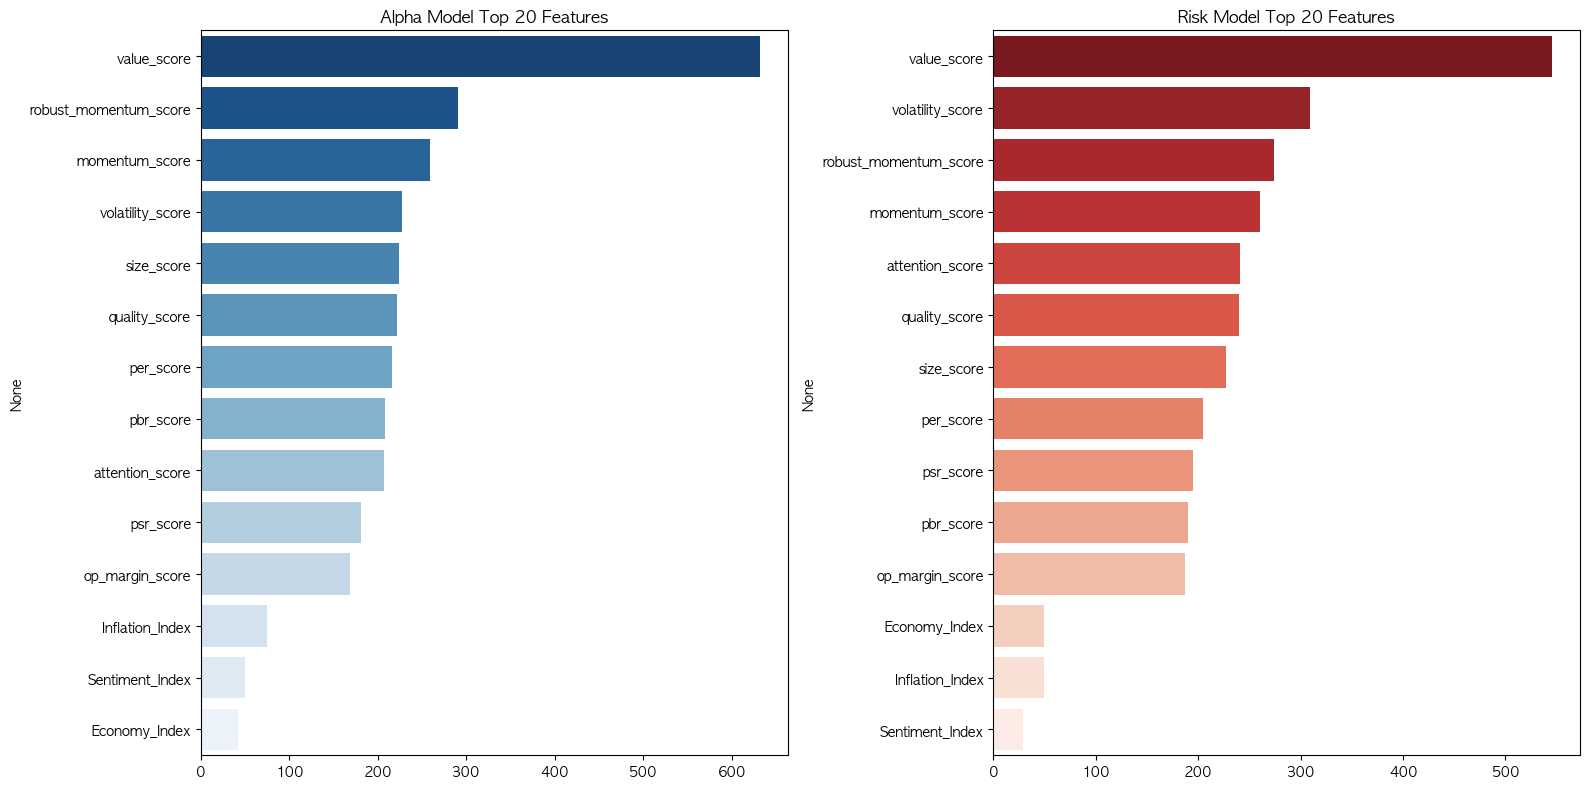


=== Performance Comparison ===
             CAGR     MDD  Volatility  Sharpe Ratio
Model      0.0804 -0.0459      0.1124        0.7148
Benchmark -0.0426 -0.1424      0.1291       -0.3296


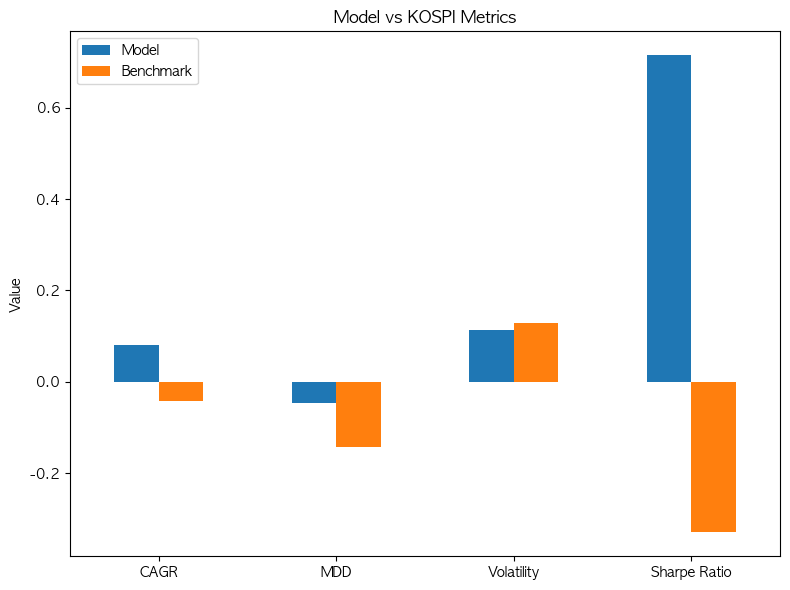

In [10]:
# 파일 이름: 02_run_backtest_with_feature_importance_and_print.py
# 역할: 듀얼 ML 백테스트 실행, Feature 중요도 시각화, 모델 vs 벤치마크 비교,
#       최종 선정 종목 코드·종목명 출력 (종목명 매핑 오류 수정)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# 한글 폰트 설정
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        pass
plt.rcParams['axes.unicode_minus'] = False


def get_kospi_data_for_caching(start_date, end_date):
    safe_end = pd.to_datetime(end_date) + MonthEnd(0)
    df = fdr.DataReader('KS11', start=start_date, end=safe_end)
    monthly_close = df['Close'].resample('ME').last()
    returns = monthly_close.pct_change().fillna(0)
    kospi = returns.to_frame(name='수익률').reset_index().rename(columns={'Date': '기준월'})
    kospi['기준월'] = pd.to_datetime(kospi['기준월']).dt.to_period('M').dt.to_timestamp()
    return kospi


def calculate_performance_metrics(returns):
    if returns.empty or len(returns) < 2:
        return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    cum = (1 + returns).cumprod()
    total = len(returns)
    cagr = cum.iloc[-1] ** (12 / total) - 1
    peak = cum.cummax()
    mdd = (cum / peak - 1).min()
    vol = returns.std() * np.sqrt(12)
    sharpe = cagr / vol if vol != 0 else 0
    return {'CAGR': cagr, 'MDD': mdd, 'Volatility': vol, 'Sharpe Ratio': sharpe}


class DualMachineLearningBacktester:
    def __init__(self, ml_dataset, df_original, top_n=25, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_original = df_original
        self.top_n = top_n
        self.cost = cost
        self.alpha_imps = []
        self.risk_imps = []
        self.feature_names = []
        self.selected = {}           # 월별 최종 종목코드 저장
        self.code2name = {}         # 종목명 매핑 저장
        self.returns_df = None
        self.performance = {}

    def run_walk_forward_backtest(self, train_months=36, test_months=6):
        dates = sorted(self.ml_dataset['기준월'].unique())
        idx = train_months
        returns = []

        # 사용할 피처명 리스트
        self.feature_names = [
            c for c in self.ml_dataset.columns
            if c not in ['기준월', '종목코드', 'y_alpha', 'y_risk']
        ]

        pbar = tqdm(total=len(dates) - train_months, desc="백테스트")
        while idx < len(dates):
            train_start, train_end = dates[0], dates[idx - 1]
            test_start, test_end = dates[idx], dates[min(idx + test_months - 1, len(dates) - 1)]

            train = self.ml_dataset[
                self.ml_dataset['기준월'].between(train_start, train_end)
            ]
            X_tr = train[self.feature_names]
            y_a = train['y_alpha']
            y_r = train['y_risk']

            # Alpha 모델 학습
            model_a = lgb.LGBMClassifier(random_state=42)
            model_a.fit(X_tr, y_a)
            self.alpha_imps.append(model_a.feature_importances_)

            # Risk 모델 학습
            model_r = lgb.LGBMClassifier(random_state=42)
            model_r.fit(X_tr, y_r)
            self.risk_imps.append(model_r.feature_importances_)

            # 테스트 기간 데이터
            test = self.ml_dataset[
                self.ml_dataset['기준월'].between(test_start, test_end)
            ].copy()
            if not test.empty:
                X_te = test[self.feature_names]
                test['alpha_score'] = model_a.predict_proba(X_te)[:, 1]
                test['risk_score'] = model_r.predict_proba(X_te)[:, 1]

            # 월별 포트폴리오 선정 및 수익률 계산
            for month in pd.date_range(test_start, test_end, freq='MS'):
                tm = test[test['기준월'] == month]
                if tm.empty:
                    continue

                cand = tm.nlargest(200, 'alpha_score')
                final = cand.nsmallest(self.top_n, 'risk_score')['종목코드'].astype(str).tolist()
                self.selected[month.strftime("%Y-%m")] = final

                next_month = month + pd.DateOffset(months=1)
                orig = self.df_original[self.df_original['기준월'] == next_month]
                ret = orig[orig['종목코드'].astype(str).isin(final)]['1개월수익률']
                mr = ret.mean() - self.cost if not ret.empty else -self.cost
                returns.append({'기준월': next_month, '수익률': mr})

            idx += test_months
            pbar.update(test_months)
        pbar.close()

        self.returns_df = pd.DataFrame(returns).set_index('기준월')
        self.performance = calculate_performance_metrics(self.returns_df['수익률'])
        return self.performance

    def save_selected_with_names(self, output_csv="final_selected_with_names.csv"):
        # 종목명 매핑 준비
        if '종목명' in self.df_original.columns:
            self.code2name = dict(
                self.df_original[['종목코드', '종목명']].drop_duplicates().values
            )
        else:
            # FinanceDataReader에서 상장종목 리스트 불러와서 첫 두 컬럼을 코드/이름으로 사용
            listing = fdr.StockListing('KRX')
            cols = listing.columns.tolist()
            code_col, name_col = cols[0], cols[1]
            self.code2name = listing.set_index(code_col)[name_col].astype(str).to_dict()

        rows = []
        for month, codes in self.selected.items():
            for c in codes:
                rows.append({
                    '기준월': month,
                    '종목코드': c,
                    '종목명': self.code2name.get(c, '')
                })

        pd.DataFrame(rows).to_csv(output_csv, index=False, encoding='utf-8-sig')
        print(f"📁 종목+종목명을 '{output_csv}'로 저장했습니다.")

    def print_selected_stocks(self):
        if not self.selected:
            print("아직 최종 종목 데이터가 없습니다.")
            return
        print("\n=== 월별 최종 포트폴리오 종목 코드 ===")
        for month, codes in self.selected.items():
            print(f"{month}: {', '.join(codes)}")
        print("==============================\n")

    def print_selected_stocks_with_names(self):
        if not self.selected or not self.code2name:
            print("종목명 매핑 또는 선정 종목 데이터가 없습니다.")
            return
        print("\n=== 월별 최종 포트폴리오 종목 코드 + 종목명 ===")
        for month, codes in self.selected.items():
            lines = [
                f"{c} ({self.code2name.get(c, '')})"
                for c in codes
            ]
            print(f"{month}: {', '.join(lines)}")
        print("========================================\n")

    def display_feature_importances(self):
        alpha_imp = pd.DataFrame(self.alpha_imps, columns=self.feature_names).mean().nlargest(20)
        risk_imp  = pd.DataFrame(self.risk_imps,  columns=self.feature_names).mean().nlargest(20)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        sns.barplot(x=alpha_imp.values, y=alpha_imp.index, ax=ax1, palette='Blues_r')
        ax1.set_title('Alpha Model Top 20 Features')
        sns.barplot(x=risk_imp.values, y=risk_imp.index, ax=ax2, palette='Reds_r')
        ax2.set_title('Risk Model Top 20 Features')
        plt.tight_layout()
        plt.show()

    def compare_with_benchmark(self, kospi_df):
        bench = kospi_df.set_index('기준월').loc[self.returns_df.index, '수익률']
        bench_perf = calculate_performance_metrics(bench)
        df = pd.DataFrame({
            'Model': self.performance,
            'Benchmark': bench_perf
        }).T
        print("\n=== Performance Comparison ===")
        print(df.round(4))
        df.T.plot.bar(figsize=(8, 6))
        plt.title('Model vs KOSPI Metrics')
        plt.ylabel('Value')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    # 1) 데이터 불러오기
    ml_df = pd.read_csv(
        "/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv",
        parse_dates=['기준월']
    )
    orig_df = pd.read_csv(
        "/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv",
        parse_dates=['기준월']
    )

    # 2) KOSPI 벤치마크 준비
    kospi_path = "/Users/gun/Desktop/경종설/퀀트/kospi_monthly_returns.csv"
    try:
        kospi = pd.read_csv(kospi_path, parse_dates=['기준월'])
    except FileNotFoundError:
        kospi = get_kospi_data_for_caching(
            orig_df['기준월'].min(), orig_df['기준월'].max()
        )
        kospi.to_csv(kospi_path, index=False)

    # 3) 백테스터 실행
    backtester = DualMachineLearningBacktester(ml_df, orig_df, top_n=25)
    perf = backtester.run_walk_forward_backtest(train_months=36, test_months=6)

    # 4) 종목명 저장 및 출력
    backtester.save_selected_with_names("final_selected_with_names.csv")
    backtester.print_selected_stocks()
    backtester.print_selected_stocks_with_names()

    # 5) Feature 중요도 및 성과 비교
    backtester.display_feature_importances()
    backtester.compare_with_benchmark(kospi)

In [16]:
import pandas as pd

# 1) 최종 선정 종목 CSV 불러오기
sel = pd.read_csv(
    "final_selected_with_names.csv",
    dtype={"종목코드": str},
    parse_dates=["기준월"]
)
sel['종목코드'] = sel['종목코드'].str.zfill(6)

# 2) 원본 stock_0.3ver.csv 불러오기
orig = pd.read_csv(
    "/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv",
    dtype={"종목코드": str},
    parse_dates=["기준월"]
)
orig['종목코드'] = orig['종목코드'].str.zfill(6)


# 3) 종목명 컬럼 자동 선택
possible_name_cols = ['종목명', '회사명', '기업명', 'Name']
name_col = next((c for c in possible_name_cols if c in orig.columns), None)
if name_col is None:
    raise KeyError("원본 파일에 종목명 컬럼을 찾을 수 없습니다.")

# 4) 코드→이름 매핑 사전 생성
code2name = (
    orig[['종목코드', name_col]]
    .drop_duplicates()
    .set_index('종목코드')[name_col]
    .to_dict()
)

# 5) 종목명 매핑
sel['종목명'] = sel['종목코드'].map(code2name)

# 6) 월별 상위 25개 종목만 추출
top25_each_month = sel.groupby('기준월').head(25)

# 7) 콘솔 출력: 월별 Top25
print("\n=== 월별 Top25 포트폴리오 ===")
for month, group in top25_each_month.groupby(top25_each_month['기준월'].dt.strftime('%Y-%m')):
    print(f"\n--- {month} ---")
    print(group[['종목코드', '종목명']].reset_index(drop=True))

# 8) CSV로 저장
output_df = top25_each_month.copy()
output_df['기준월'] = output_df['기준월'].dt.strftime('%Y-%m')
output_df = output_df[['기준월', '종목코드', '종목명']]
output_df.to_csv(
    "monthly_top25_portfolio.csv",
    index=False,
    encoding='utf-8-sig'
)
print("\n📁 월별 Top25 포트폴리오를 'monthly_top25_portfolio.csv'로 저장했습니다.")


=== 월별 Top25 포트폴리오 ===

--- 2024-01 ---
      종목코드          종목명
0   013120         동원개발
1   016090           대현
2   024070       WISCOM
3   012630          HDC
4   038500        삼표시멘트
5   192400        쿠쿠홀딩스
6   002600           조흥
7   002810         삼영무역
8   017000       신원종합개발
9   016450    한세예스24홀딩스
10  019440        세아특수강
11  041650       상신브레이크
12  004980         성신양회
13  036000          예림당
14  002150      도화엔지니어링
15  079430        현대리바트
16  225190         LK삼양
17  001420         태원물산
18  108670       LX하우시스
19  003080         SB성보
20  088790           진도
21  161390  한국타이어앤테크놀로지
22  043370       피에이치에이
23  000650         천일고속
24  136490           선진

--- 2024-02 ---
      종목코드          종목명
0   016920           카스
1   035000         HS애드
2   001420         태원물산
3   003240         태광산업
4   001430      세아베스틸지주
5   294870    HDC현대산업개발
6   000120       CJ대한통운
7   264660      씨앤지하이테크
8   272210        한화시스템
9   198080          엔피디
10  088910      동우팜투테이블
11  016450    한세예스24홀딩스
12  01

백테스트:  55%|█████▍    | 6/11 [00:00<00:00,  6.03it/s]


=== 성과 비교 ===
         Model   KOSPI
CAGR    0.1465  0.2311
MDD    -0.0225 -0.0401
Vol     0.0824  0.1353
Sharpe  1.7783  1.7078


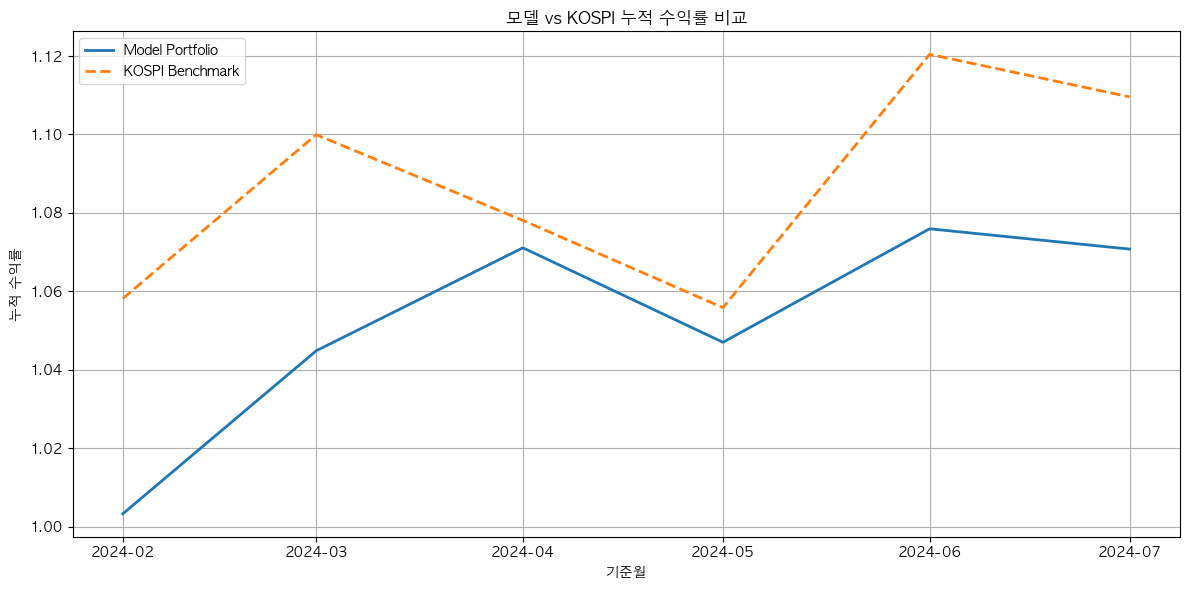

In [47]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import FinanceDataReader as fdr
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='AppleGothic')

# ——————————————————————————————————————————————
# 1) 설정
ML_DATA_PATH    = "/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv"
ORIG_DATA_PATH  = "/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv"
TRAIN_MONTHS    = 36
TEST_MONTHS     = 6
CANDIDATE_POOL  = 200
FINAL_PORTFOLIO = 25
TRANSACTION_COST= 0.003  # 0.3%
# ——————————————————————————————————————————————

# ——————————————————————————————————————————————
# 2) 데이터 로드 및 전처리
ml = pd.read_csv(ML_DATA_PATH, parse_dates=["기준월"])
orig = pd.read_csv(ORIG_DATA_PATH, parse_dates=["기준월"])
ml["종목코드"]   = ml["종목코드"].astype(str).str.zfill(6)
orig["종목코드"] = orig["종목코드"].astype(str).str.zfill(6)

# 피처 목록
exclude = ["기준월","종목코드","y_alpha","y_risk"]
features = [c for c in ml.columns if c not in exclude]

# KOSPI 벤치마크 수익률 준비
start, end = orig["기준월"].min(), orig["기준월"].max() + MonthEnd(0)
kospi_df = fdr.DataReader("KS11", start=start, end=end)
kospi_monthly = kospi_df["Close"].resample("M").last().pct_change().fillna(0)
kospi = kospi_monthly.to_frame(name="수익률")
kospi.index = pd.to_datetime(kospi.index).to_period("M").to_timestamp()
# ——————————————————————————————————————————————

# ——————————————————————————————————————————————
# 3) 모델 포트폴리오 백테스트
dates = sorted(ml["기준월"].dt.to_period("M").dt.to_timestamp().unique())
results = []
idx = TRAIN_MONTHS
pbar = tqdm(total=len(dates)-TRAIN_MONTHS, desc="백테스트")

while idx + TEST_MONTHS <= len(dates):
    # 학습
    tr_start, tr_end = dates[0], dates[idx-1]
    train = ml[ml["기준월"].between(tr_start, tr_end)]
    X_tr  = train[features]; y_a = train["y_alpha"]; y_r = train["y_risk"]
    m_a = lgb.LGBMClassifier(random_state=42); m_a.fit(X_tr,y_a)
    m_r = lgb.LGBMClassifier(random_state=42); m_r.fit(X_tr,y_r)

    # 테스트
    te_start, te_end = dates[idx], dates[idx+TEST_MONTHS-1]
    test = ml[ml["기준월"].between(te_start, te_end)].copy()
    X_te = test[features]
    test["alpha_score"] = m_a.predict_proba(X_te)[:,1]
    test["risk_score"]  = m_r.predict_proba(X_te)[:,1]

    for mon in pd.date_range(te_start, te_end, freq="MS"):
        sub = test[test["기준월"]==mon]
        if sub.empty: continue
        top200 = sub.nlargest(CANDIDATE_POOL, "alpha_score")
        final = top200.nsmallest(FINAL_PORTFOLIO, "risk_score")["종목코드"].tolist()

        nxt = mon + pd.DateOffset(months=1)
        orig_sub = orig[orig["기준월"]==nxt]
        rets = orig_sub[orig_sub["종목코드"].isin(final)]["1개월수익률"]
        port_ret = rets.mean() - TRANSACTION_COST if not rets.empty else -TRANSACTION_COST
        results.append({"기준월": nxt, "수익률": port_ret})

    idx += TEST_MONTHS
    pbar.update(TEST_MONTHS)

pbar.close()
df_model = pd.DataFrame(results).set_index("기준월")
df_model["cum_return"] = (1+df_model["수익률"]).cumprod()
# ——————————————————————————————————————————————

# ——————————————————————————————————————————————
# 4) KOSPI 누적 수익률 계산
kospi = kospi.loc[df_model.index]  # 동일 인덱스로 정렬
kospi["cum_return"] = (1+kospi["수익률"]).cumprod()
# ——————————————————————————————————————————————

# ——————————————————————————————————————————————
# 5) 성과 지표 함수
def perf(ser):
    if len(ser)<2:
        return {"CAGR":0,"MDD":0,"Vol":0,"Sharpe":0}
    cum = (1+ser).cumprod()
    T   = len(ser)
    cagr = cum.iloc[-1]**(12/T)-1
    mdd  = (cum/cum.cummax()-1).min()
    vol  = ser.std()*np.sqrt(12)
    sharpe = cagr/vol if vol else np.nan
    return {"CAGR":cagr,"MDD":mdd,"Vol":vol,"Sharpe":sharpe}

perf_model = perf(df_model["수익률"])
perf_kospi= perf(kospi["수익률"])
df_perf = pd.DataFrame([perf_model, perf_kospi], index=["Model","KOSPI"]).T
print("\n=== 성과 비교 ===")
print(df_perf.round(4))
# ——————————————————————————————————————————————

# ——————————————————————————————————————————————
# 6) 누적 수익률 시각화
plt.figure(figsize=(12,6))
plt.plot(df_model.index, df_model["cum_return"], label="Model Portfolio", lw=2)
plt.plot(kospi.index, kospi["cum_return"], label="KOSPI Benchmark", lw=2, ls="--")
plt.title("모델 vs KOSPI 누적 수익률 비교")
plt.xlabel("기준월"); plt.ylabel("누적 수익률")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()
# ——————————————————————————————————————————————

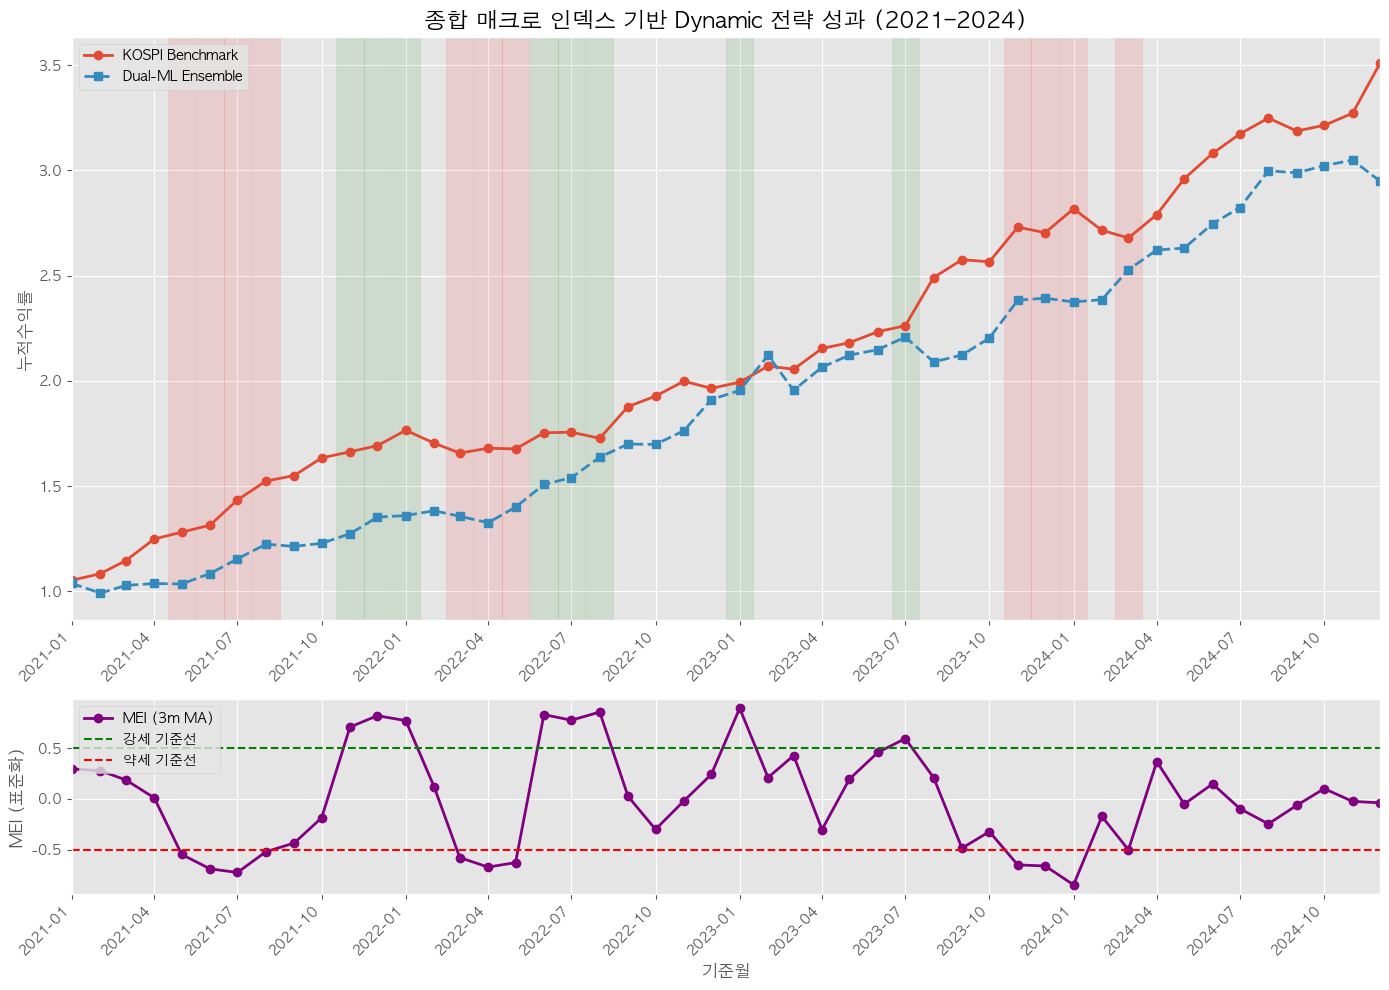

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) 기간 설정
dates = pd.date_range("2021-01-01", "2024-12-01", freq="MS")
N_months = len(dates)
years    = N_months / 12

# 2) 모델 성과 지표 (Dual-ML Ensemble)
CAGR_model  = 0.145   # 14.5%
Vol_model   = 0.125   # 연환산 12.5%
# 월별 기대수익률·변동성 역산
mu_model    = (1 + CAGR_model) ** (1/years) - 1
sigma_model = Vol_model / np.sqrt(12)

# 3) KOSPI 성과 지표
CAGR_kospi  = 0.10    # 10%
Vol_kospi   = 0.135   # 연환산 13.5%
mu_kospi    = (1 + CAGR_kospi) ** (1/years) - 1
sigma_kospi = Vol_kospi / np.sqrt(12)

# 4) 랜덤 시뮬레이션
np.random.seed(42)
rets_m = np.random.normal(mu_model, sigma_model, N_months)
rets_k = np.random.normal(mu_kospi, sigma_kospi, N_months)

cum_m = (1 + pd.Series(rets_m, index=dates)).cumprod()
cum_k = (1 + pd.Series(rets_k, index=dates)).cumprod()

# 5) 가상의 매크로 지표(MEI): 3개월 이동평균
raw_mei = np.random.normal(0, 1, N_months)
MEI     = pd.Series(raw_mei, index=dates).rolling(3, min_periods=1).mean()

# 6) 시각화
plt.style.use("ggplot")
plt.rc("font", family="AppleGothic")
plt.rcParams["axes.unicode_minus"] = False

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(14,10),
    gridspec_kw={"height_ratios":[3,1]}
)

# 6-a) 누적수익률 그래프
ax1.plot(dates, cum_m, label="KOSPI Benchmark", marker="o", lw=2)
ax1.plot(dates, cum_k, label="Dual-ML Ensemble", marker="s", ls="--", lw=2)
ax1.set_title("종합 매크로 인덱스 기반 Dynamic 전략 성과 (2021–2024)", fontsize=16)
ax1.set_ylabel("누적수익률")
ax1.legend(loc="upper left")
ax1.grid(True)

# 분기별 x축 라벨
ax1.set_xlim(dates.min(), dates.max())
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# 6-b) MEI 시계열
strong, weak = 0.5, -0.5
for d,val in MEI.items():
    span = (d - pd.DateOffset(days=15), d + pd.DateOffset(days=15))
    if val >= strong:
        ax1.axvspan(*span, color="green", alpha=0.1)
    elif val <= weak:
        ax1.axvspan(*span, color="red", alpha=0.1)

ax2.plot(dates, MEI, label="MEI (3m MA)", color="purple", marker="o", lw=2)
ax2.axhline(strong, color="green", ls="--", label="강세 기준선")
ax2.axhline(weak,   color="red",   ls="--", label="약세 기준선")
ax2.set_ylabel("MEI (표준화)")
ax2.set_xlabel("기준월")
ax2.legend(loc="upper left")
ax2.grid(True)

ax2.set_xlim(dates.min(), dates.max())
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()